<a href="https://www.kaggle.com/code/tvt2404/dacshutech?scriptVersionId=234645873" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## DDoS Defense: A Multiclass and Multidimensional Detection System with Diverse Machine Learning Models
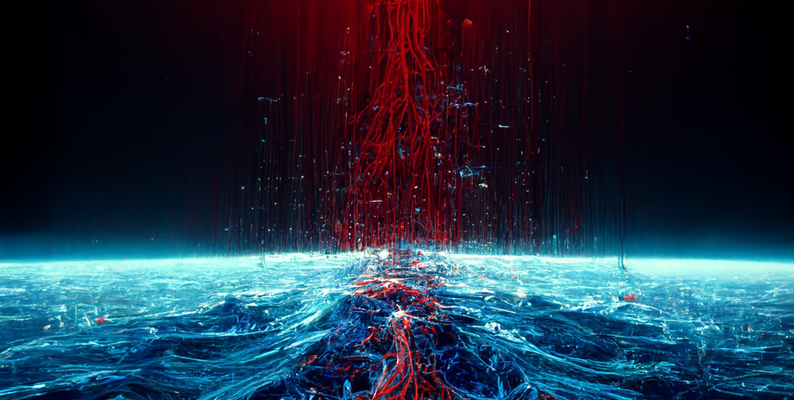
### Project Overview

This project is focused on building a system to detect and classify **DDoS (Distributed Denial of Service)** attacks using the **CICDDoS2019** dataset. The goal is to develop a multiclass classification model that can identify various DDoS attacks from normal network traffic. The dataset consists of multiple attack types with different network traffic characteristics, making it a challenging problem for DDoS detection.

### Dataset Description

The **CICDDoS2019** dataset, provided by the Canadian Institute for Cybersecurity (CIC), contains network traffic data representing several types of DDoS attacks along with benign (non-attack) traffic. The dataset features several attributes like packet size, source/destination IPs, and protocol types. The target variable consists of different attack labels as follows:

- **Syn**: SYN flood attack
- **Benign**: Normal, non-attack traffic
- **Portmap**: Portmapper-based DDoS attack
- **UDP**: Generic UDP flood attack
- **UDPLag**: UDP-based DDoS with lag
- **MSSQL**: MSSQL-specific DDoS attack
- **NetBIOS**: NetBIOS-related DDoS attack
- **LDAP**: Lightweight Directory Access Protocol-based attack

### Process Overview

#### Data Collection and Preprocessing
1. **Collecting Data Paths**:
   - The paths of training and testing datasets are collected using a file walk through. 
   - We ensure that only the datasets with matching names are used for training and testing.

2. **Data Processing**:
   - **Column Mapping**: We map the column names between the training and testing datasets, ensuring they are consistent. The column names in the testing set are renamed to match the training set.
   - **Null and Duplicate Handling**: We check for any null or duplicate values. No null values are found, and any duplicates in the dataset are removed.
   - **Removing Single Unique Value Columns**: Columns with only a single unique value are dropped as they do not provide meaningful information for classification.
   - **Removing Highly Correlated Columns**: Columns with a correlation coefficient of 0.8 or higher are dropped to reduce multicollinearity and improve model performance.

#### Exploratory Data Analysis (EDA)
Several key visualizations were performed to understand the dataset:

- **Distribution of Categorical Columns**: 
   - Frequency distribution using bar plots and percentage distribution using pie charts for categorical features.
- **Flow Duration Distribution**: 
   - Analyzing the flow duration distribution for both DDoS and normal traffic.
- **Packet Length Mean by Protocol and Attack Label**: 
   - Exploring the average packet length by protocol type and attack label.
- **Flags Distribution by Attack Label**: 
   - Distribution of different flag types across attack labels.
- **Protocol Requests Distribution**: 
   - Number of requests coming from different protocols.
- **Correlation Matrix**: 
   - A heatmap to visualize the correlation matrix and identify relationships between features.

#### Data Preprocessing and Feature Engineering
- **Train-Test Split**: 
   - The dataset is split into training, validation, and test sets to ensure proper evaluation of the model.
- **Feature Encoding**: 
   - The target column is encoded using **LabelEncoder** to convert categorical labels into numerical values for training.
- **Feature Scaling**: 
   - We apply **Min-Max Scaling** to scale the features to a uniform range, improving the performance of distance-based algorithms.

#### Model Training and Evaluation
- **Model Selection**: 
   - Several models are trained and evaluated for multiclass classification, including:
     - **Tranfomer**
     - **Convolutional Neural Network (CNN)**
     - **Long Short-Term Memory (LSTM)**
   
- **Model Evaluation**:
   - We evaluate the models using various performance metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**.
   - ROC curves are plotted to compare the performance of each model across different classes.
   - A table of the model scores is created and displayed for easy comparison.

#### Results Visualization
- **Model Comparison**: 
   - We plot the **accuracy score** for each model to visually compare their performance.
   - ROC curves for all models are plotted to analyze their classification ability, especially for multiclass classification tasks.


## Import Libraries

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE    
# Thêm các thư viện cho CNN, LSTM và Transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import Adam
from collections import Counter


import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Collecting Training and Testing Dataset File Paths
dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk('C:/Users/Podo/Downloads/DACS/CICDDoS2019/'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

In [ ]:
# Common Prefixes in both lists
train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]

In [ ]:
print("✅ dfps_train:", dfps_train)
print("✅ dfps_test:", dfps_test)
print("✅ common_prefixes:", common_prefixes)


In [ ]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [ ]:
print(train_df.shape, test_df.shape)

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

## Data Preprocessing

In [ ]:
# Check the target distribution of the training data
print(train_df["Label"].value_counts())

In [ ]:
# Check the target distribution of the testing data
print(test_df["Label"].value_counts())

The `WebDDoS` label is not present in the training data, so we will not be able to use it for training. We will remove it from the testing data.

In [ ]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

The target column values are not matching in the training and testing data. We will replace the target values in the testing data with the values present in the training data.

In [ ]:
# Map the labels to the same format
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',  # Already matches
    'Benign': 'Benign'  # Already matches
}

test_df["Label"] = test_df["Label"].map(label_mapping)

In [ ]:
# Check the target distribution of the testing data after mapping
print(test_df["Label"].value_counts())

In [ ]:
# Display the columns of the training data
train_df.columns

#ity columns.

In [ ]:
le = LabelEncoder()
train_df["Label"] = le.fit_transform(train_df["Label"])
test_df["Label"] = le.transform(test_df["Label"])

In [ ]:
#### Find the categorical columns, numerical columns, categorical but high cardinal
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    high_card_cat_cols = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols

cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

In [ ]:
# Display the unique values of the categorical columns
for i in cat_cols:
    print(i, train_df[i].unique())

In [ ]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

### Missing Values

In [ ]:
# Total number of missing values
print(f"Total number of missing values: {train_df.isnull().sum().sum()}")

### Duplicate Rows

In [ ]:
print(f"Number of Duplicate Rows: {train_df.duplicated().sum()}")

In [ ]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

# Exploratory Data Analysis (EDA)


### Categorical Columns

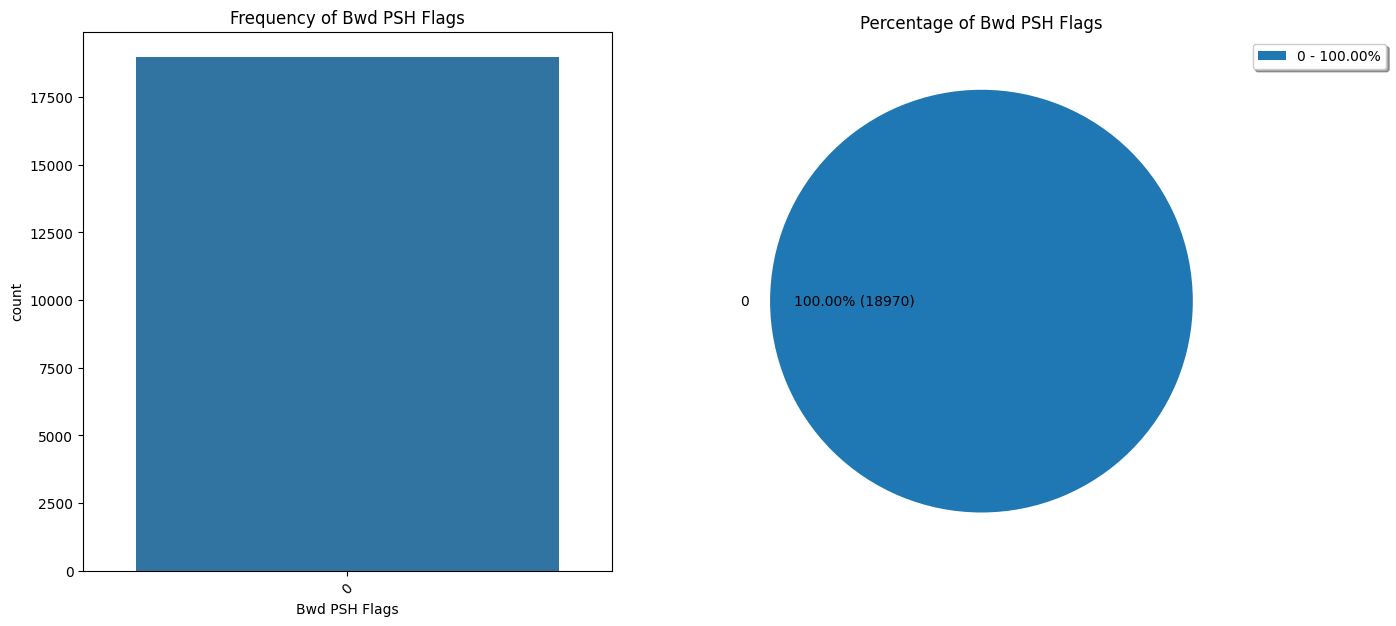

               Fwd URG Flags  Ratio
Fwd URG Flags                      
0                      18970  100.0




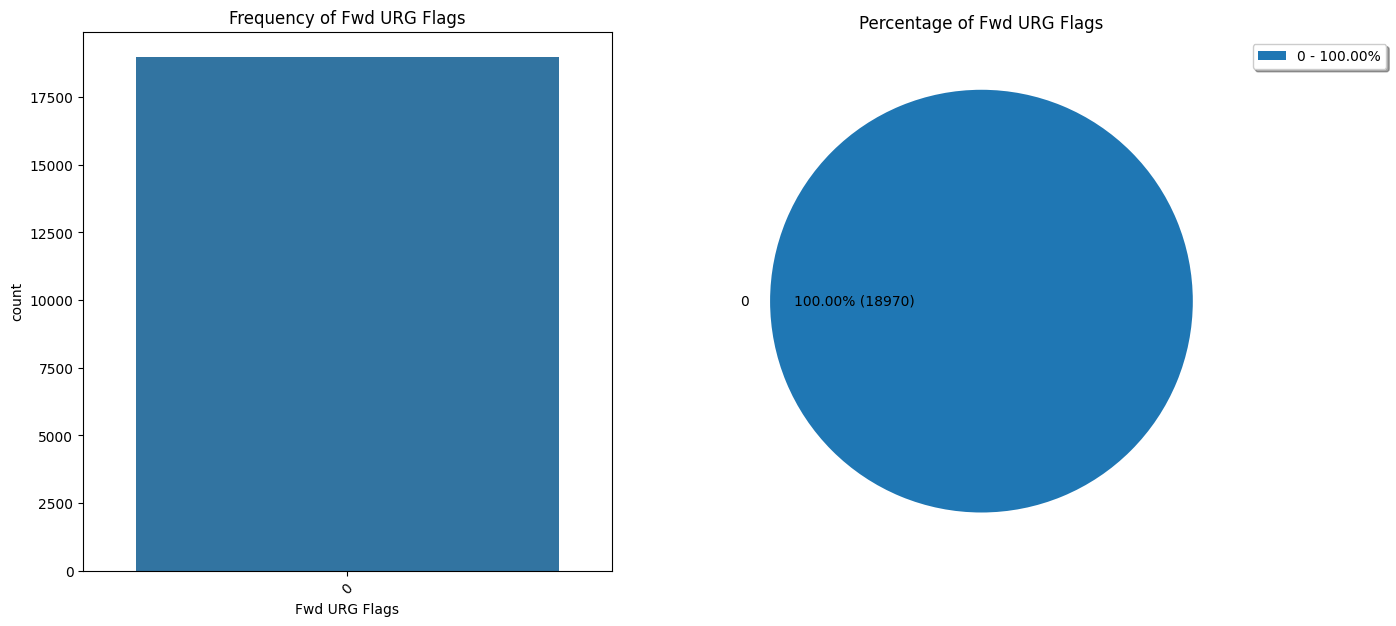

               Bwd URG Flags  Ratio
Bwd URG Flags                      
0                      18970  100.0




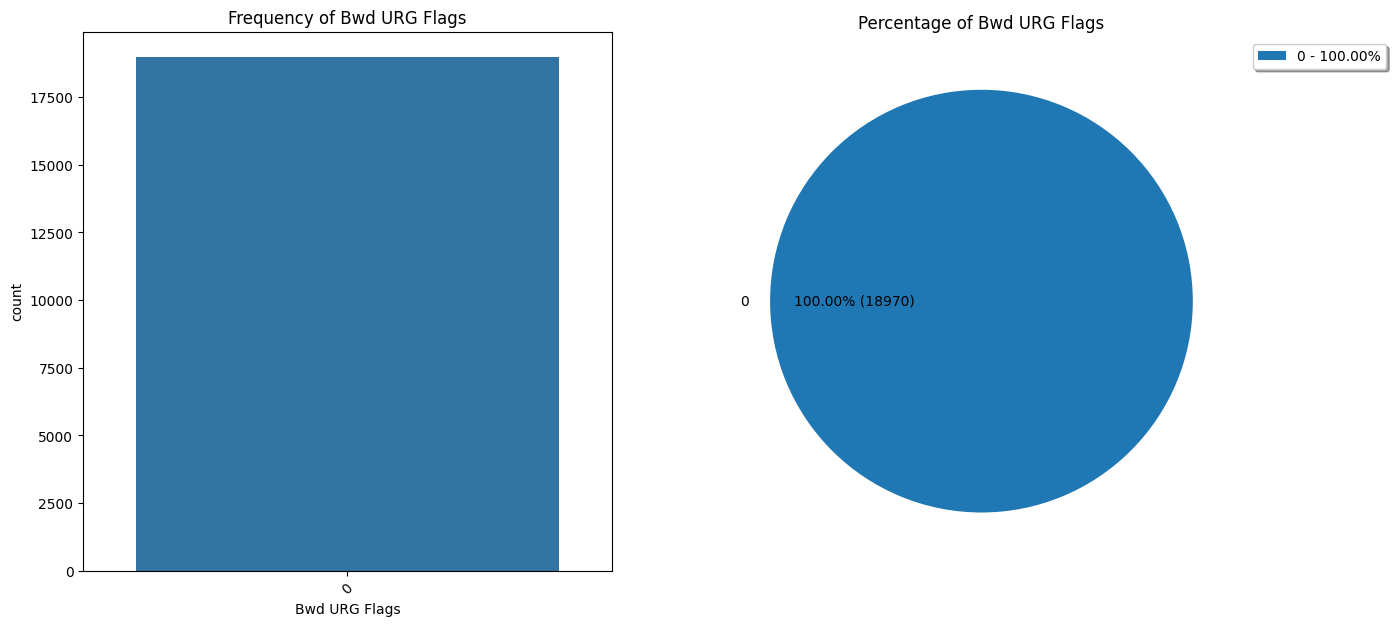

                FIN Flag Count  Ratio
FIN Flag Count                       
0                        18970  100.0




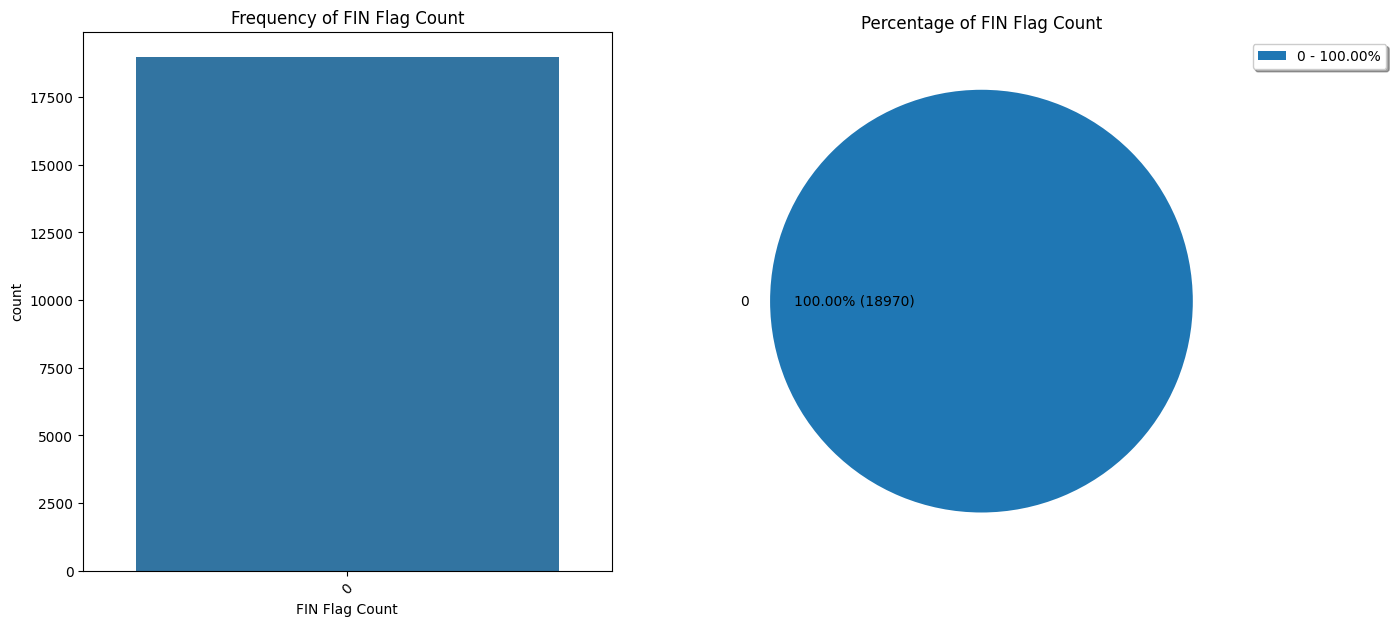

                SYN Flag Count      Ratio
SYN Flag Count                           
0                        18949  99.889299
1                           21   0.110701




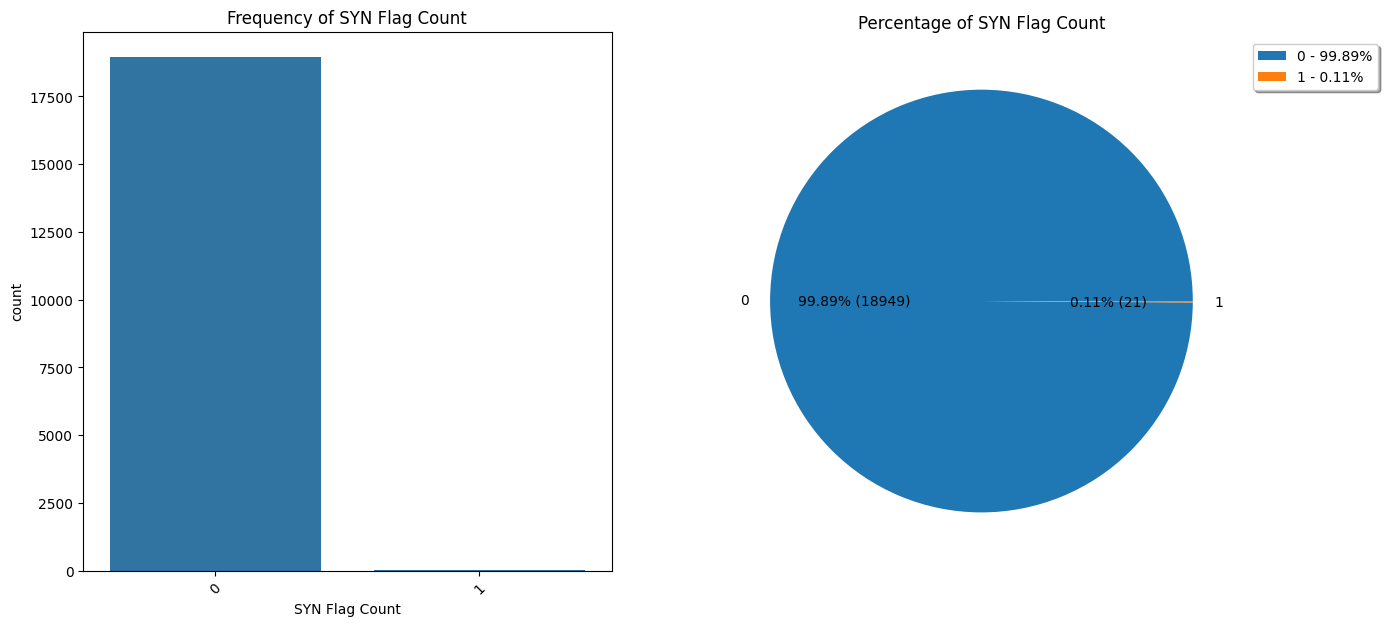

                RST Flag Count      Ratio
RST Flag Count                           
0                        17514  92.324723
1                         1456   7.675277




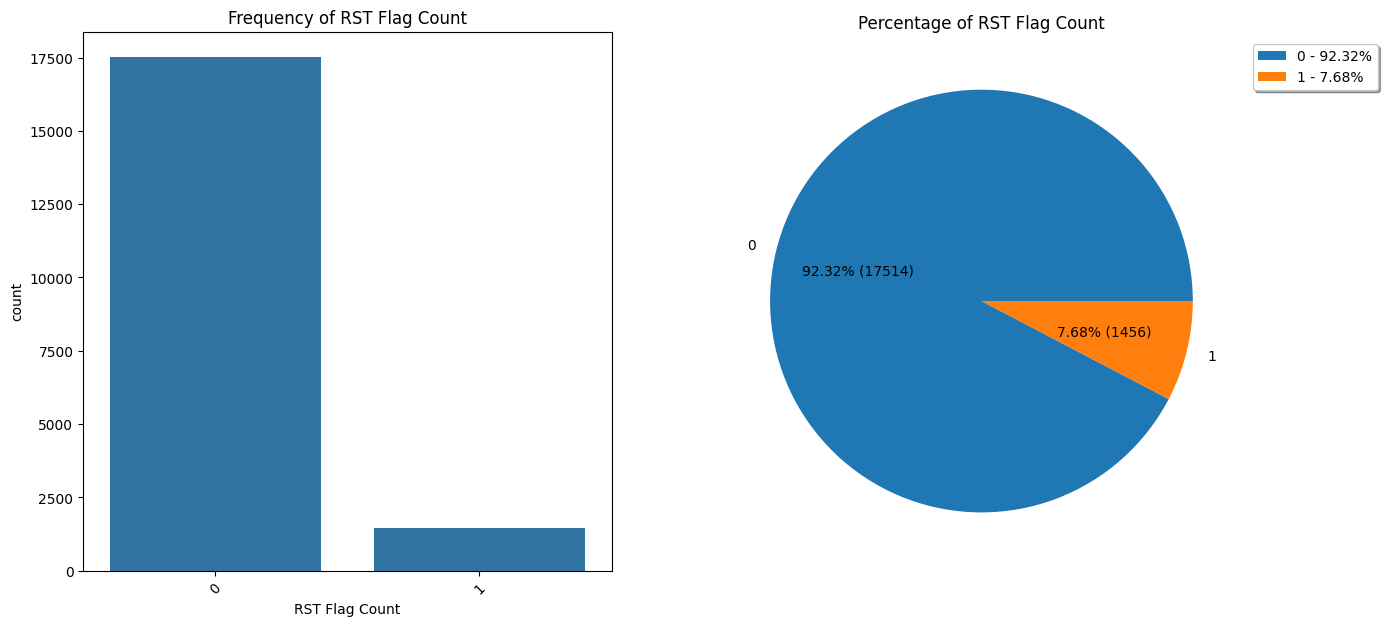

                PSH Flag Count  Ratio
PSH Flag Count                       
0                        18970  100.0




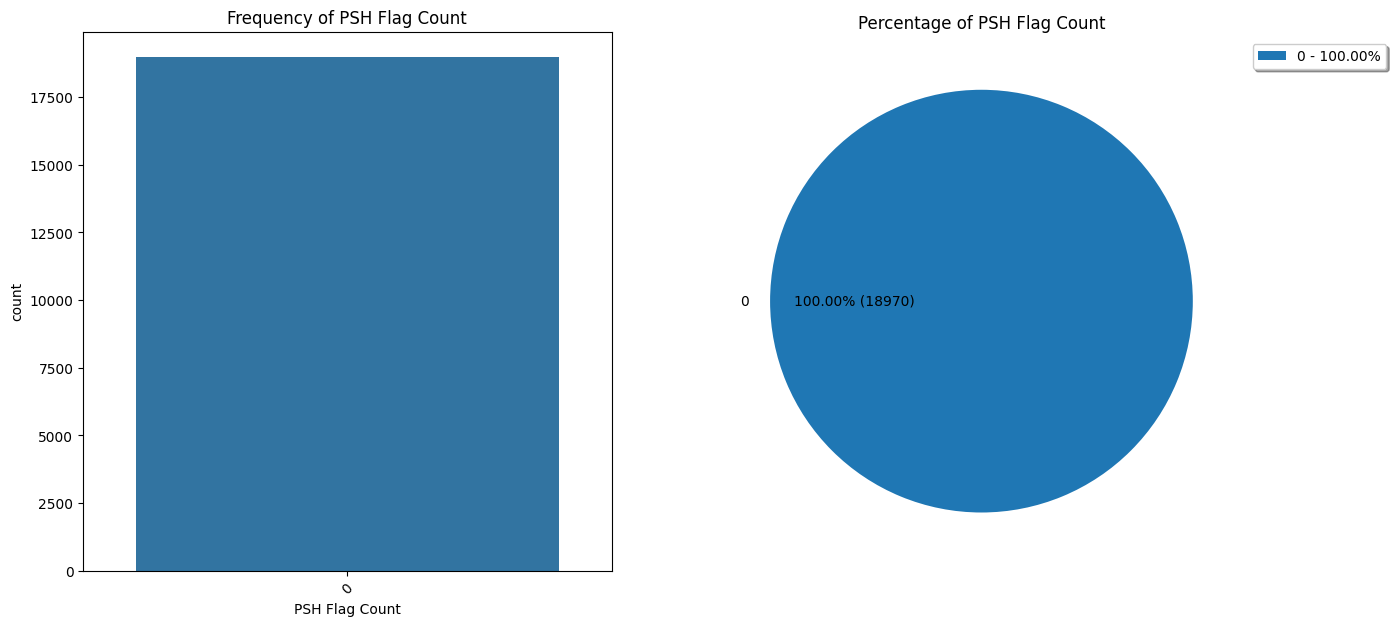

                ACK Flag Count      Ratio
ACK Flag Count                           
0                        17483  92.161307
1                         1487   7.838693




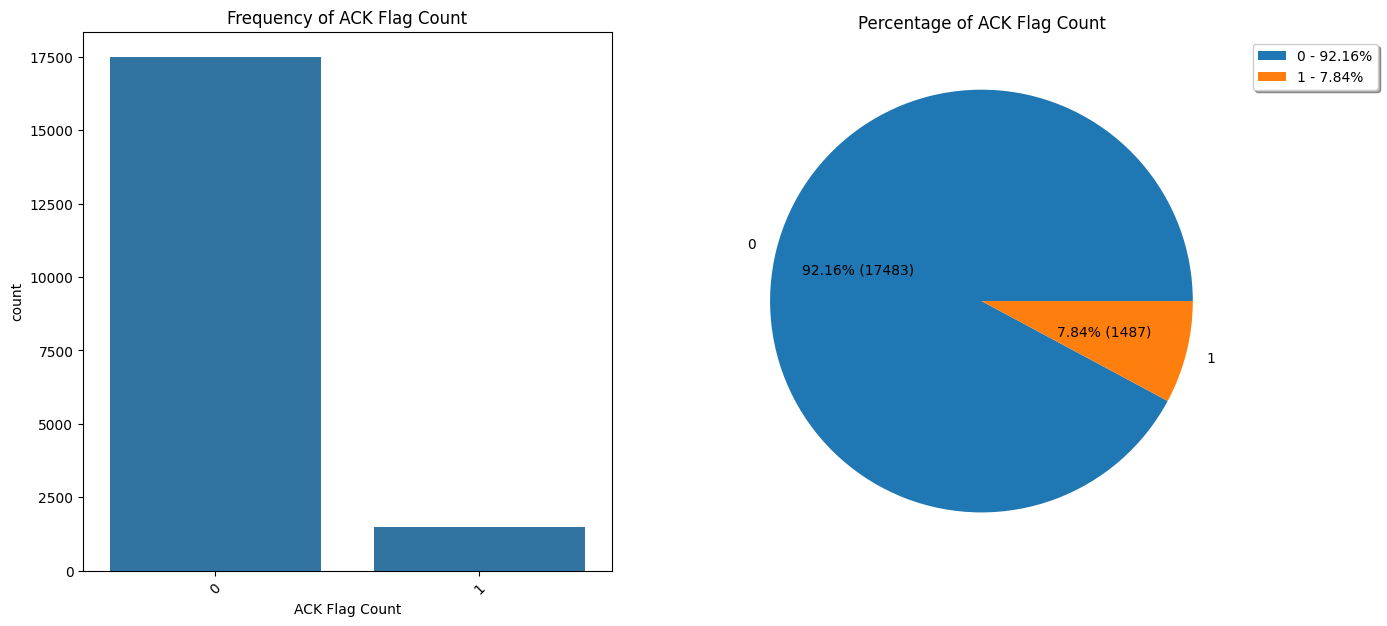

                URG Flag Count      Ratio
URG Flag Count                           
0                        14138  74.528202
1                         4832  25.471798




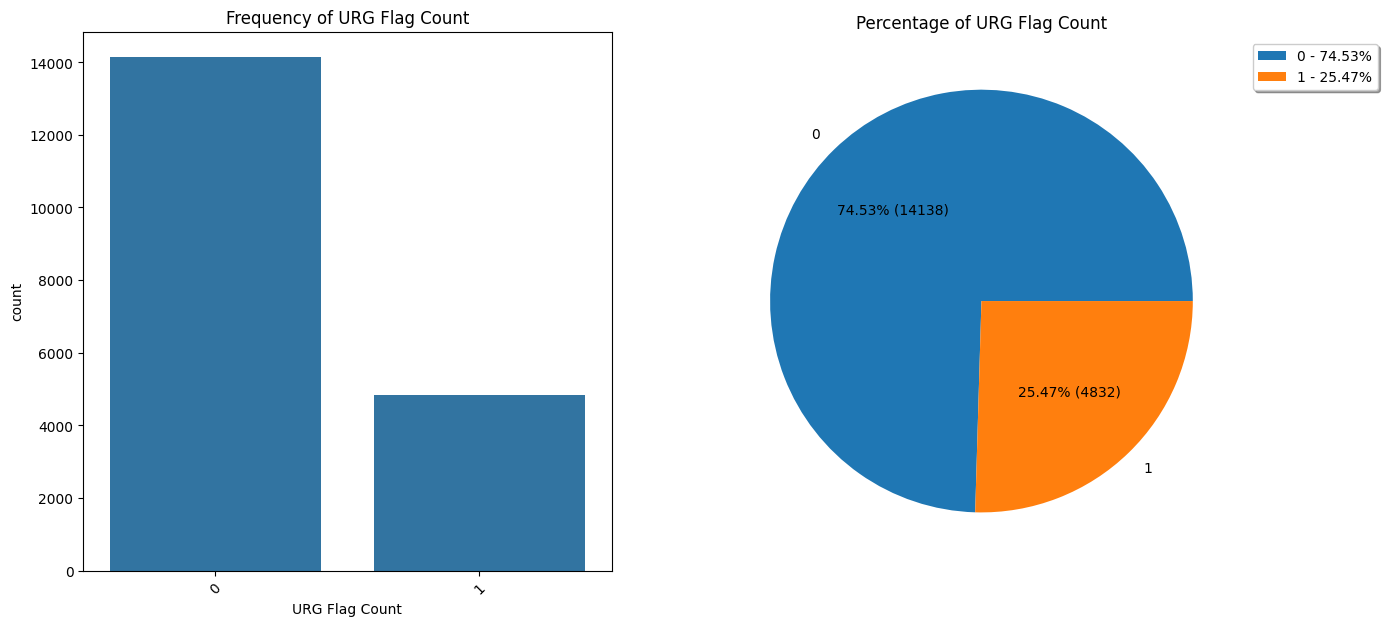

                CWE Flag Count      Ratio
CWE Flag Count                           
0                        17382  91.628888
1                         1588   8.371112




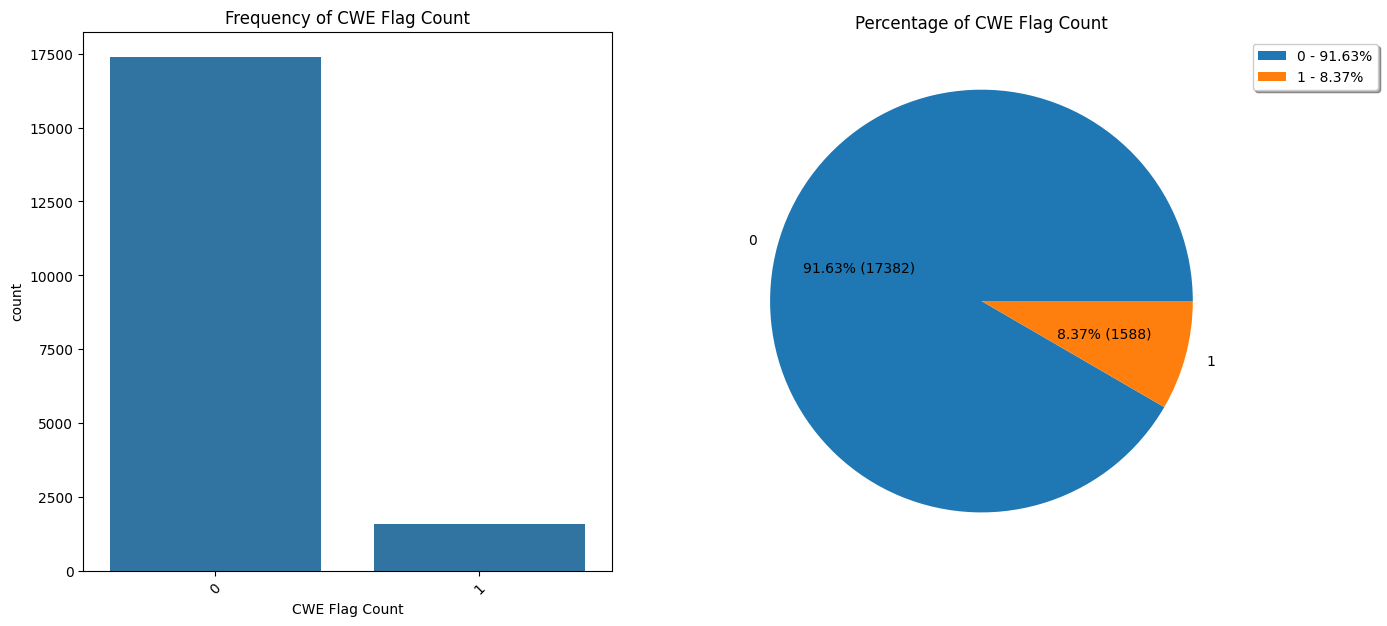

                ECE Flag Count  Ratio
ECE Flag Count                       
0                        18970  100.0




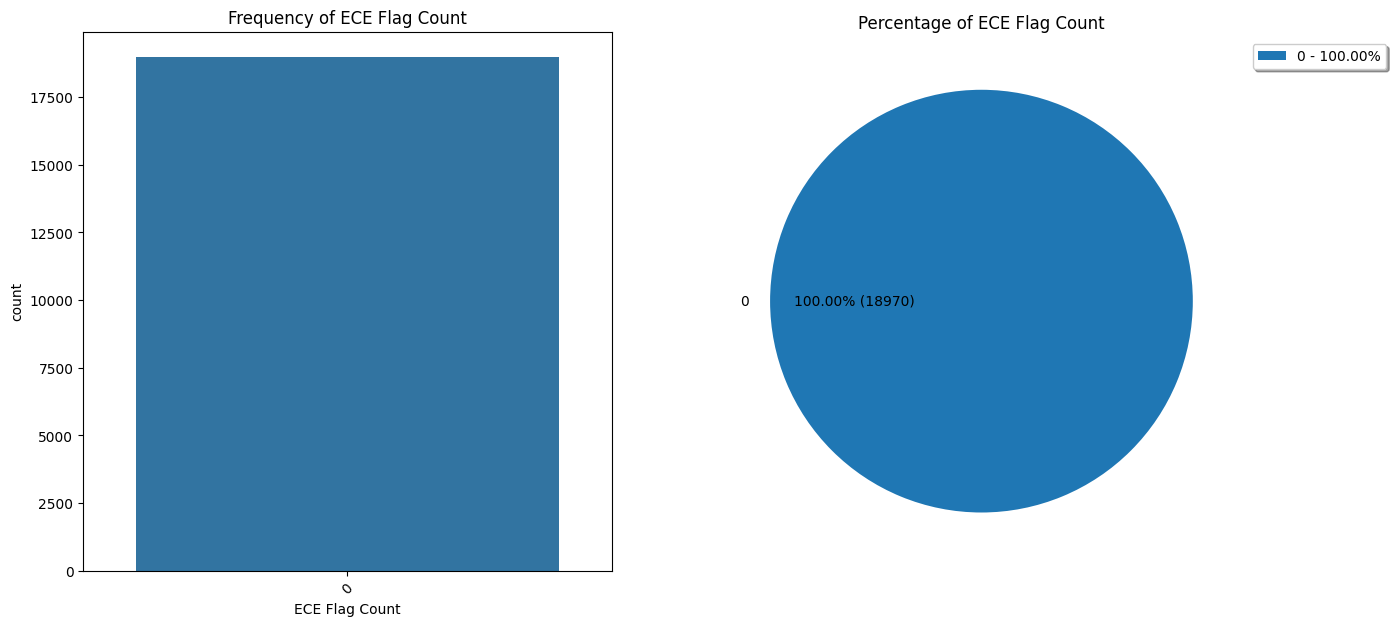

               Down/Up Ratio      Ratio
Down/Up Ratio                          
0.0                    14030  73.958882
1.0                     3804  20.052715
2.0                      737   3.885082
3.0                      244   1.286241
4.0                      124   0.653664
5.0                       27   0.142330
8.0                        2   0.010543
10.0                       1   0.005271
7.0                        1   0.005271




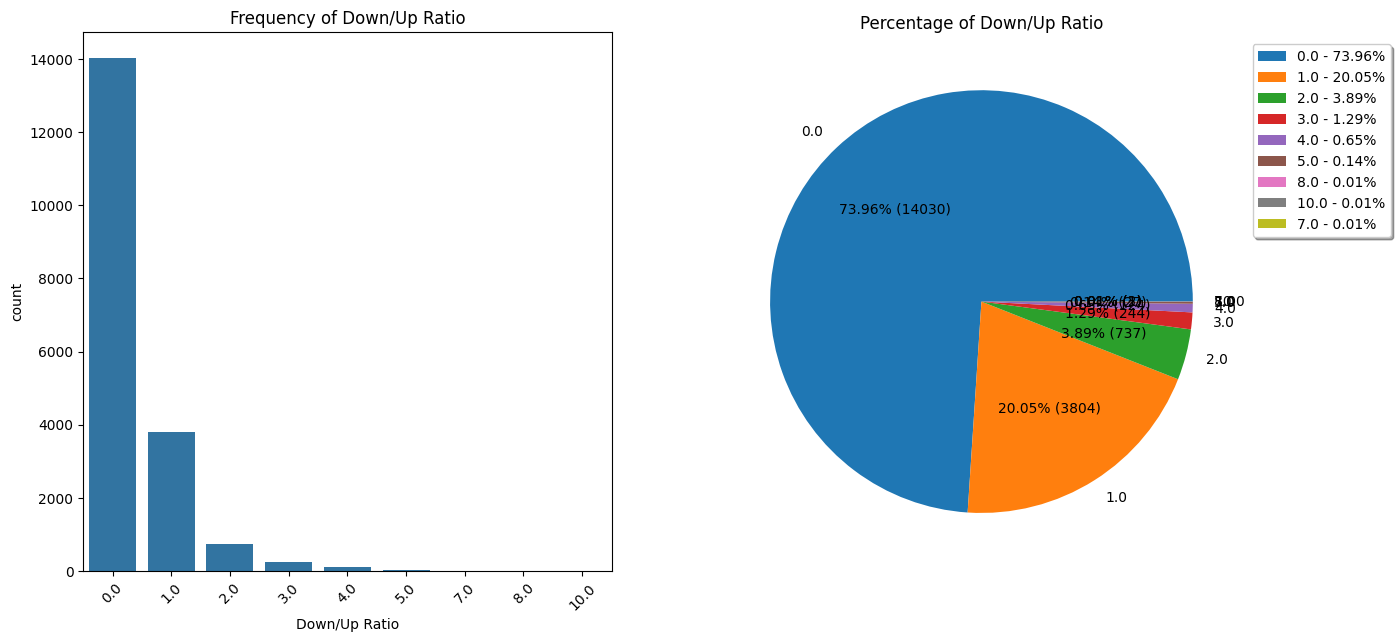

                    Fwd Avg Bytes/Bulk  Ratio
Fwd Avg Bytes/Bulk                           
0                                18970  100.0




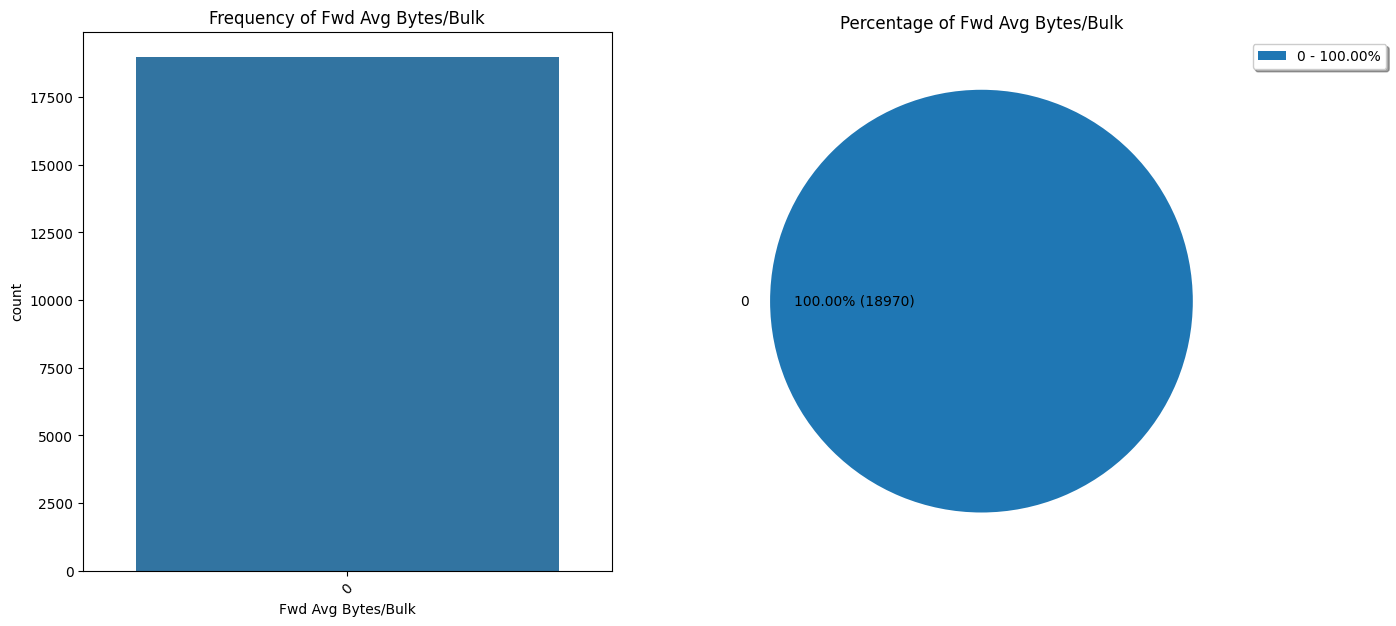

                      Fwd Avg Packets/Bulk  Ratio
Fwd Avg Packets/Bulk                             
0                                    18970  100.0




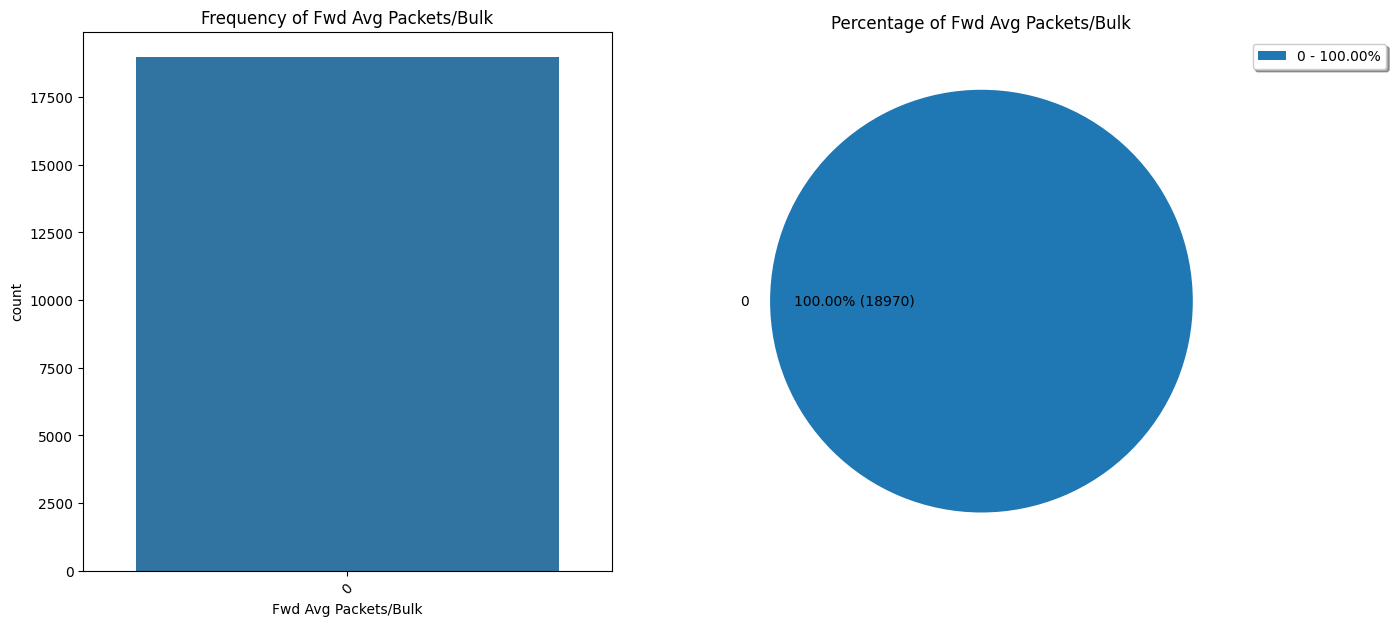

                   Fwd Avg Bulk Rate  Ratio
Fwd Avg Bulk Rate                          
0                              18970  100.0




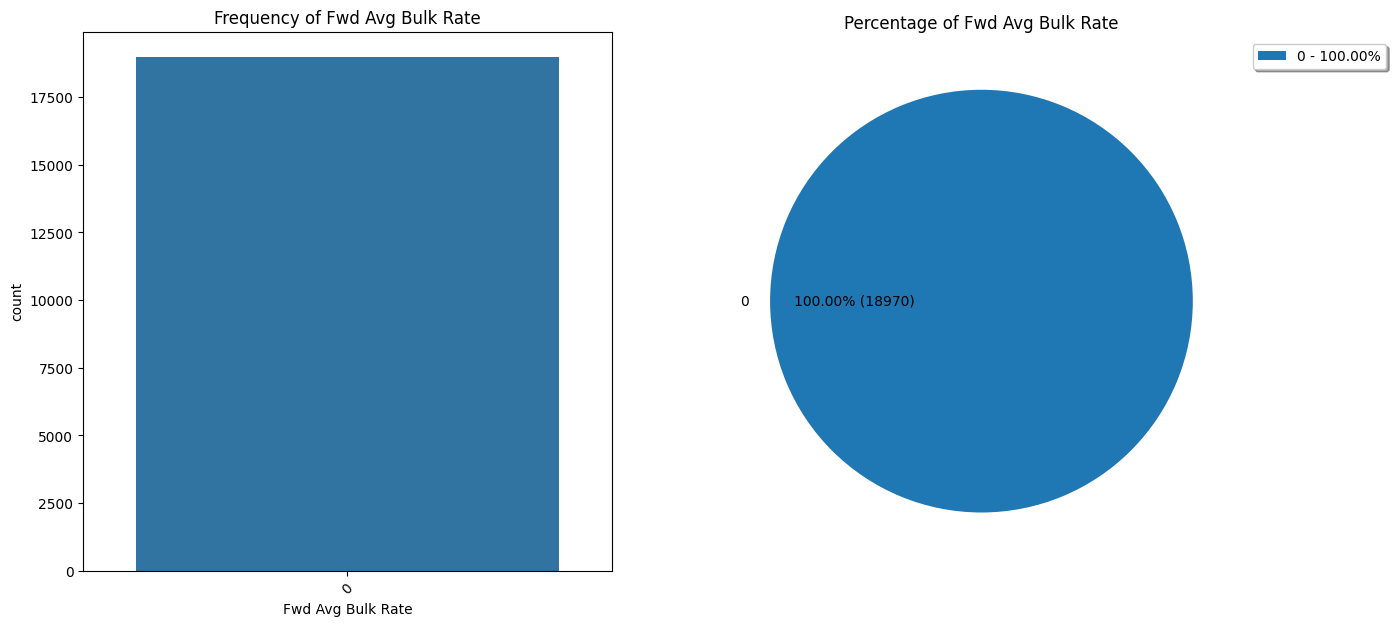

                    Bwd Avg Bytes/Bulk  Ratio
Bwd Avg Bytes/Bulk                           
0                                18970  100.0




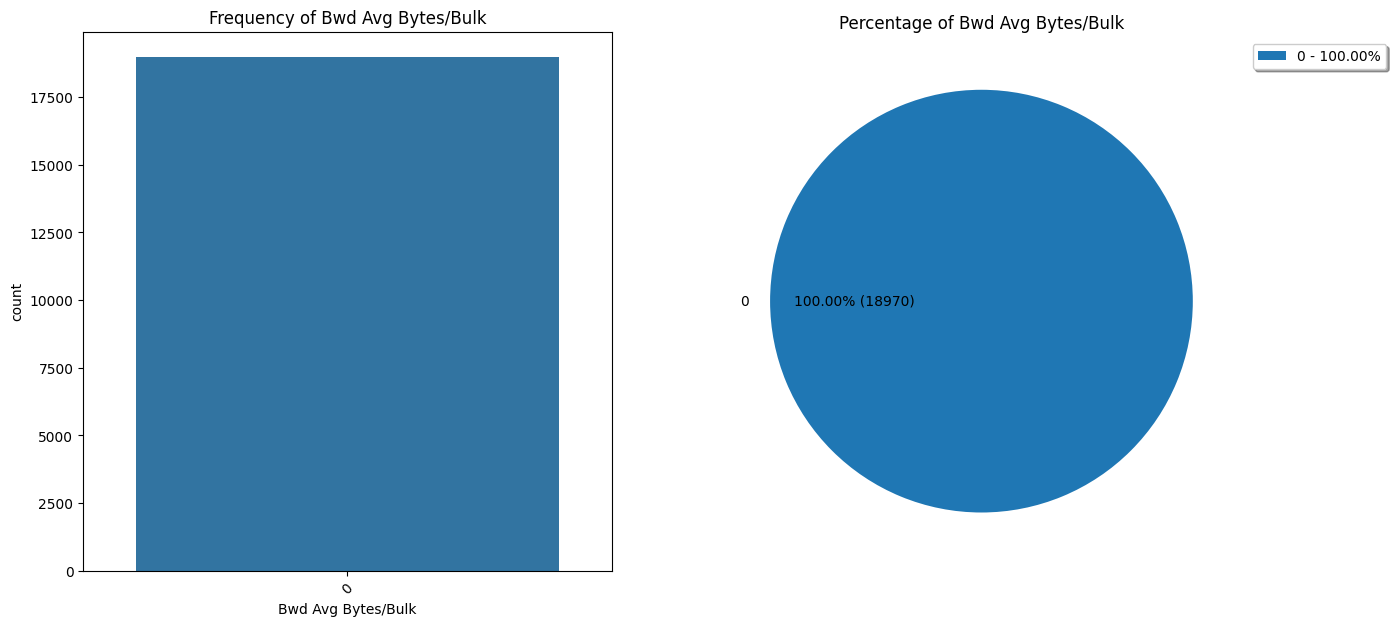

                      Bwd Avg Packets/Bulk  Ratio
Bwd Avg Packets/Bulk                             
0                                    18970  100.0




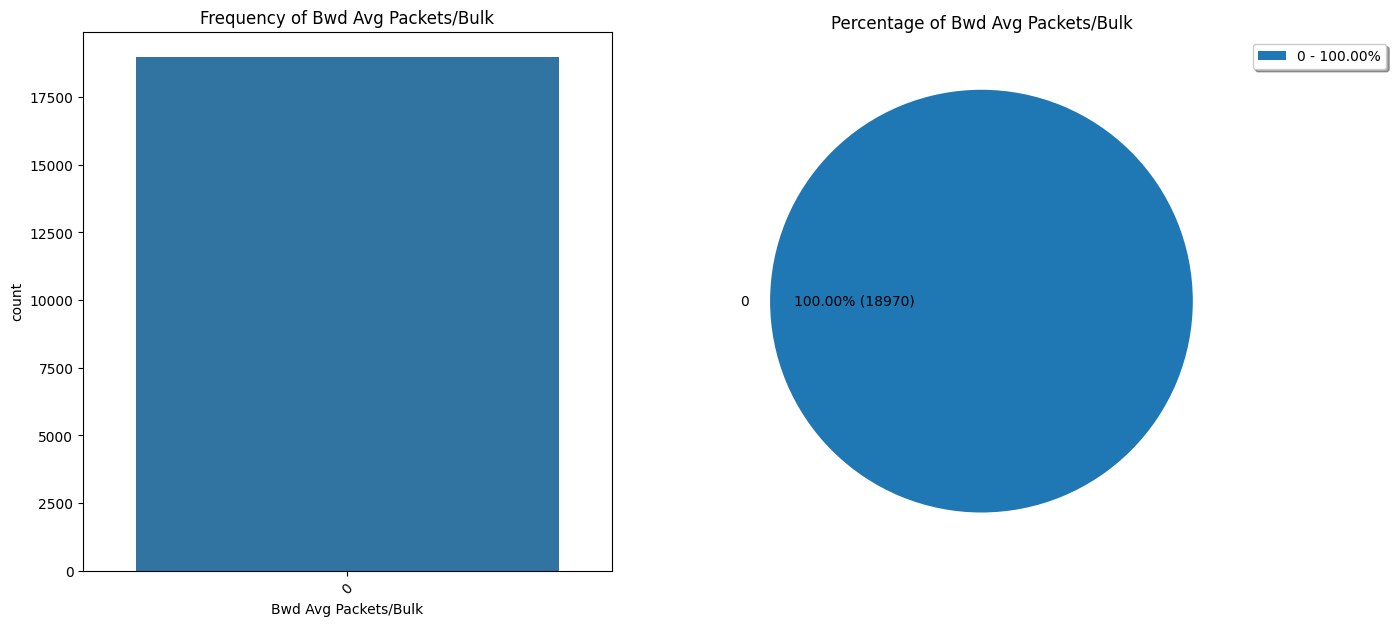

                   Bwd Avg Bulk Rate  Ratio
Bwd Avg Bulk Rate                          
0                              18970  100.0




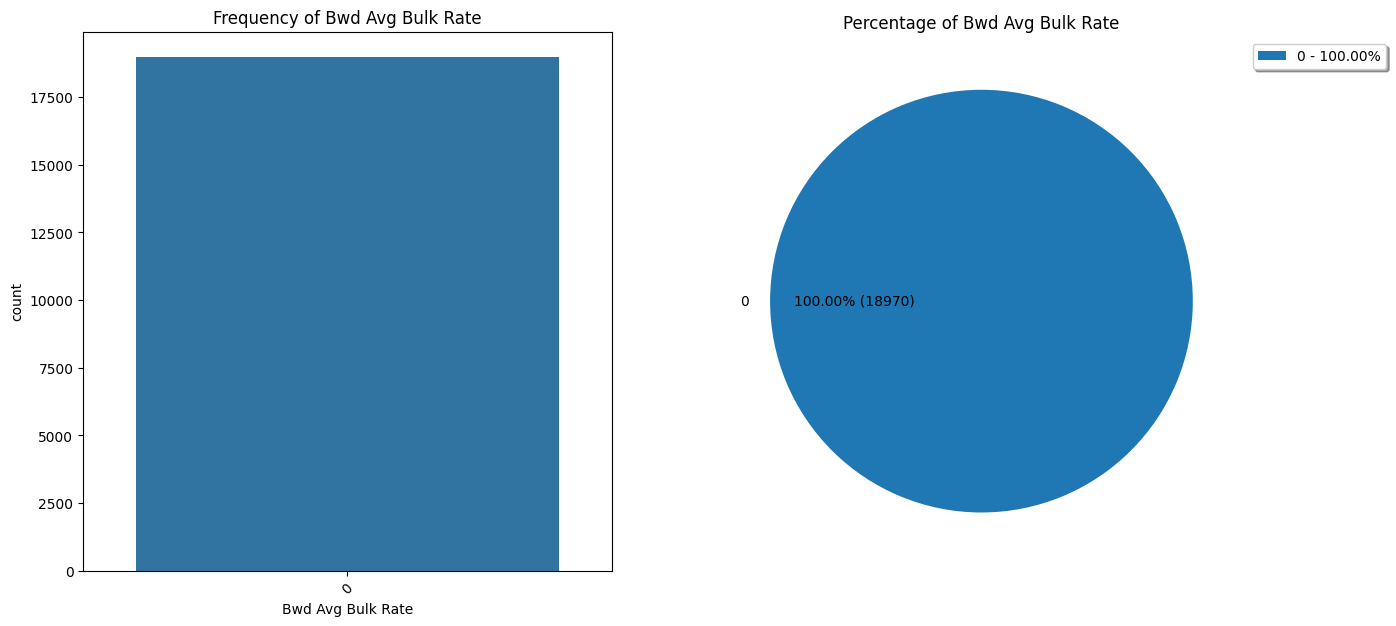

       Label      Ratio
Label                  
2       8378  44.164470
0       8232  43.394834
1       1885   9.936742
3        475   2.503954




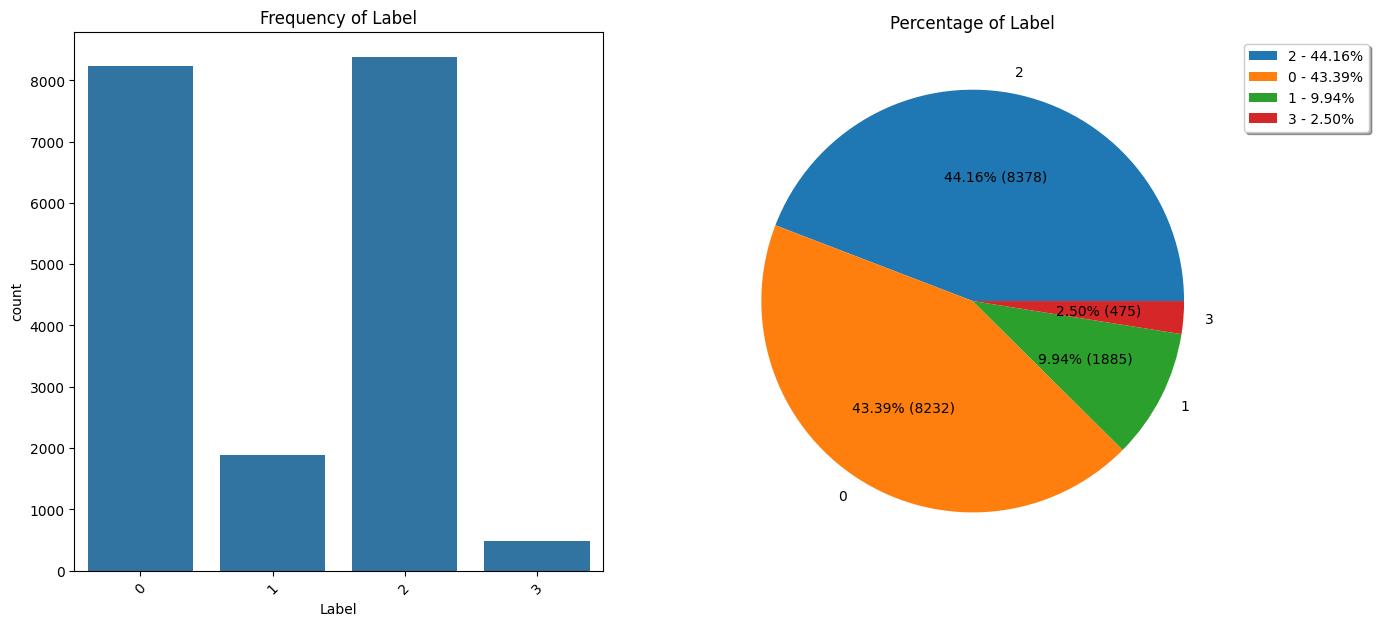

In [88]:
def cat_summary(data, col, plot=False):
    print(pd.DataFrame({col: data[col].value_counts(), "Ratio": data[col].value_counts() / len(data) * 100}))
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
        plt.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
                   loc="upper left",
                   bbox_to_anchor=(1, 1),
                   fancybox=True,
                   shadow=True,
                   ncol=1)
        plt.title(f"Percentage of {col}")
        plt.show(block=True)

for col in cat_cols:
    cat_summary(train_df, col, True)

# Numberical Columns

In [89]:
# Distribution Plots for Numerical Columns
def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")

def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")

def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")

# Relational Plots for Numerical Columns
def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")

def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")

# Categorical Plots for Categorical Columns
def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
    ax.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
              loc="upper left",
              bbox_to_anchor=(1, 1),
              fancybox=True,
              shadow=True,
              ncol=1)
    ax.set_title(f"Pie Chart of {col}")

def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)

def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)

def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)

# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size: plt.figure(figsize=size)
    sns.heatmap(data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12})
    plt.title("Correlation Matrix")
    plt.show()

def plot_charts_grid_single_feature(data, plot_func, size=(12, 4), n_col=1):
    if len(data.columns) == 0:
        return
    n_rows = (len(data.columns) + n_col - 1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(data.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        plot_func(data, col, axes[i])

    for j in range(i+1, n_rows*n_col):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [90]:
# plot_charts_grid_single_feature(train_df[num_cols], my_histplot, size=(12, 4), n_col=2)

In [91]:
#plot_charts_grid_single_feature(train_df[num_cols], my_boxplot, size=(2, 4), n_col=6)

### Packet Size and Flow Duration Analysis

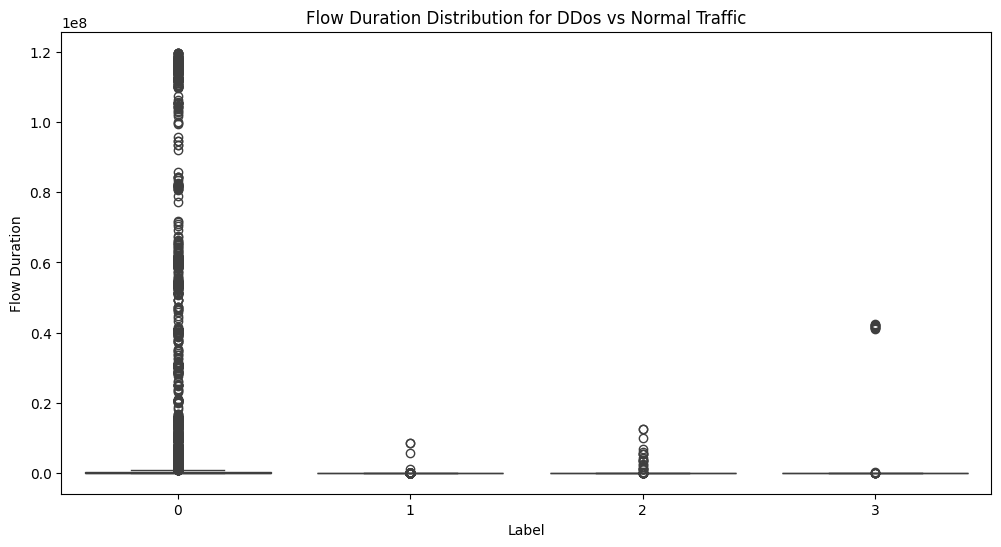

In [92]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=train_df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

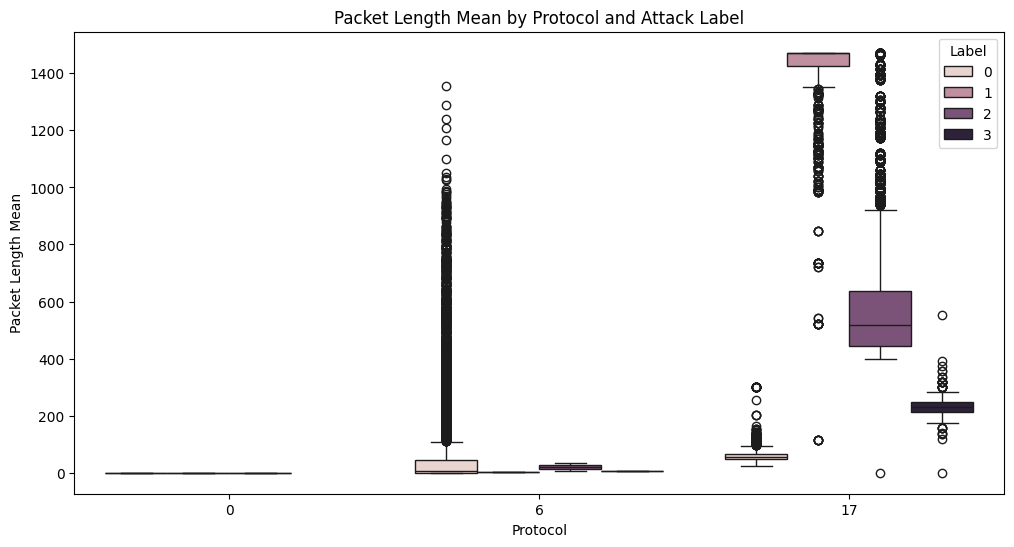

In [93]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=train_df)
plt.title("Packet Length Mean by Protocol and Attack Label")
plt.show()

### Packet Flags and Attack Patterns

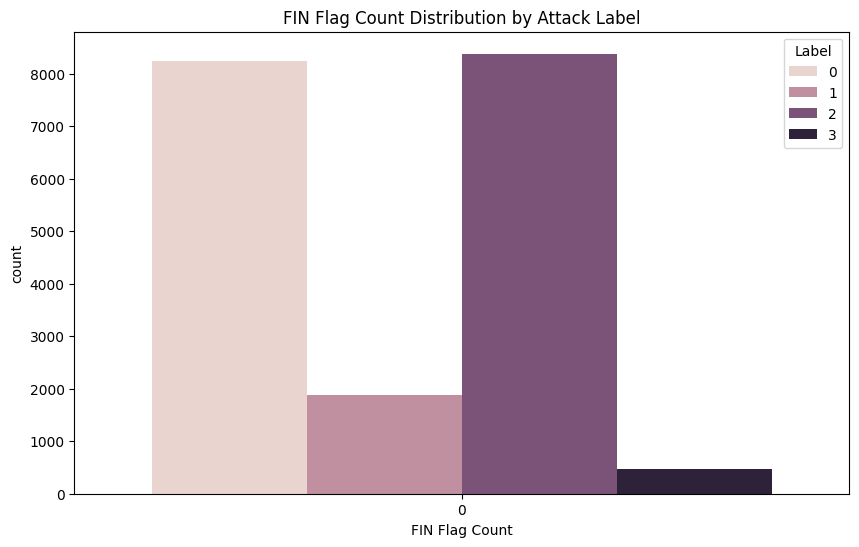

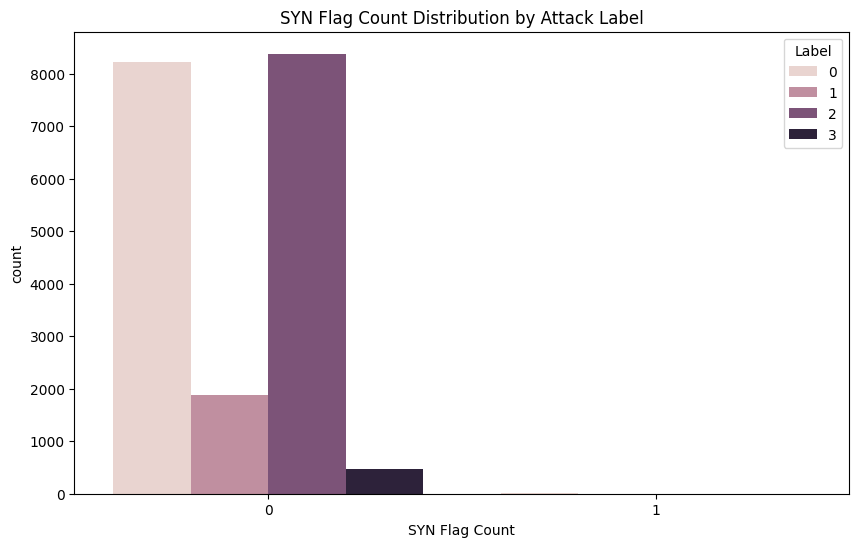

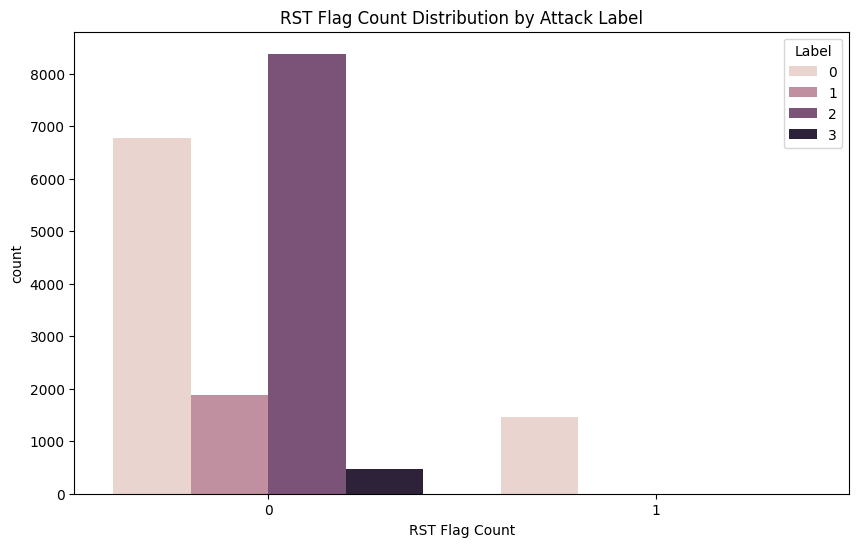

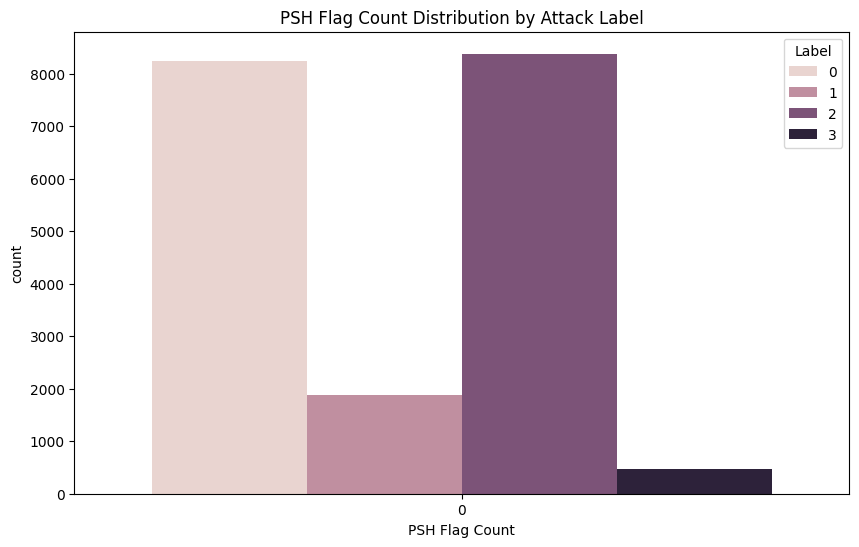

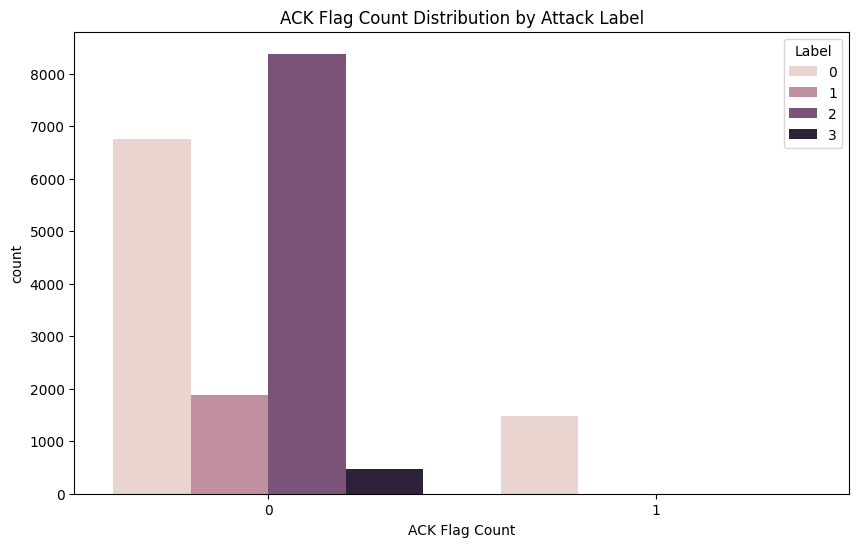

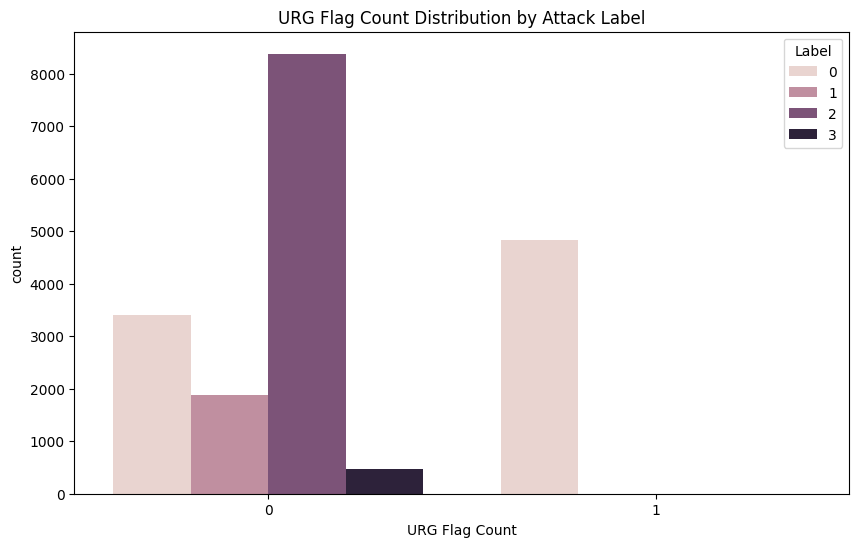

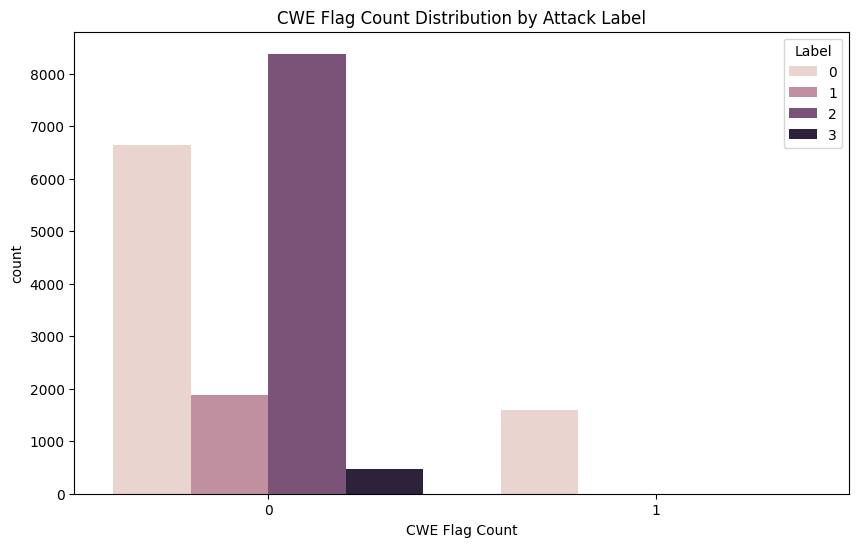

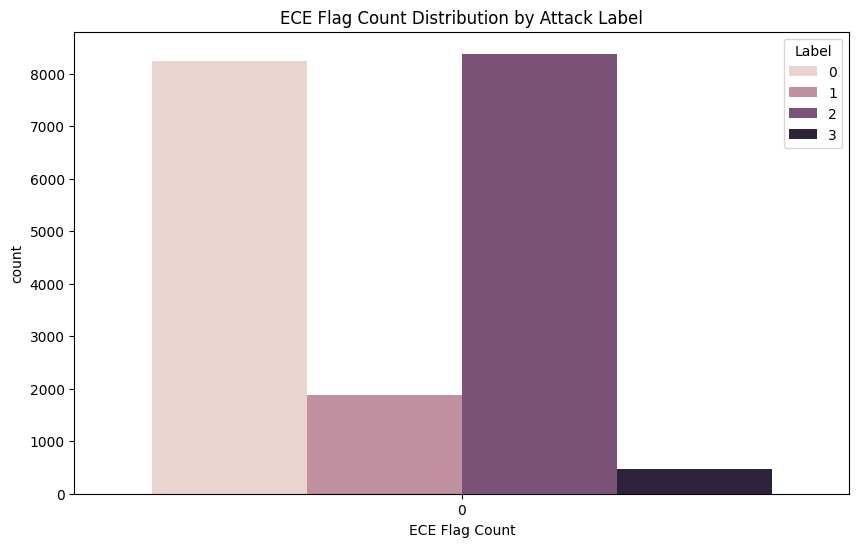

In [94]:
# Counting the number of occurrences of each flag in attack vs normal traffic
flag_cols = [col for col in train_df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=train_df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()


### Requests from Different Protocols

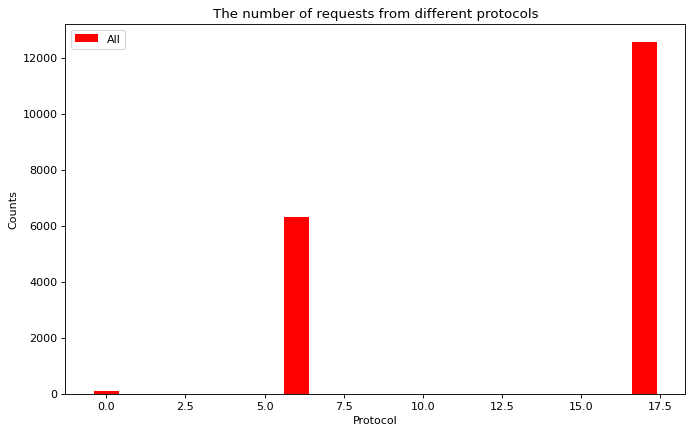

In [95]:
# Protocol distribution
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(train_df["Protocol"].value_counts()).keys()), dict(train_df["Protocol"].value_counts()).values(), color='r')

plt.xlabel("Protocol")
plt.ylabel("Counts")
plt.legend(["All"])
plt.title("The number of requests from different protocols")
plt.show()

### Correlation Matrix

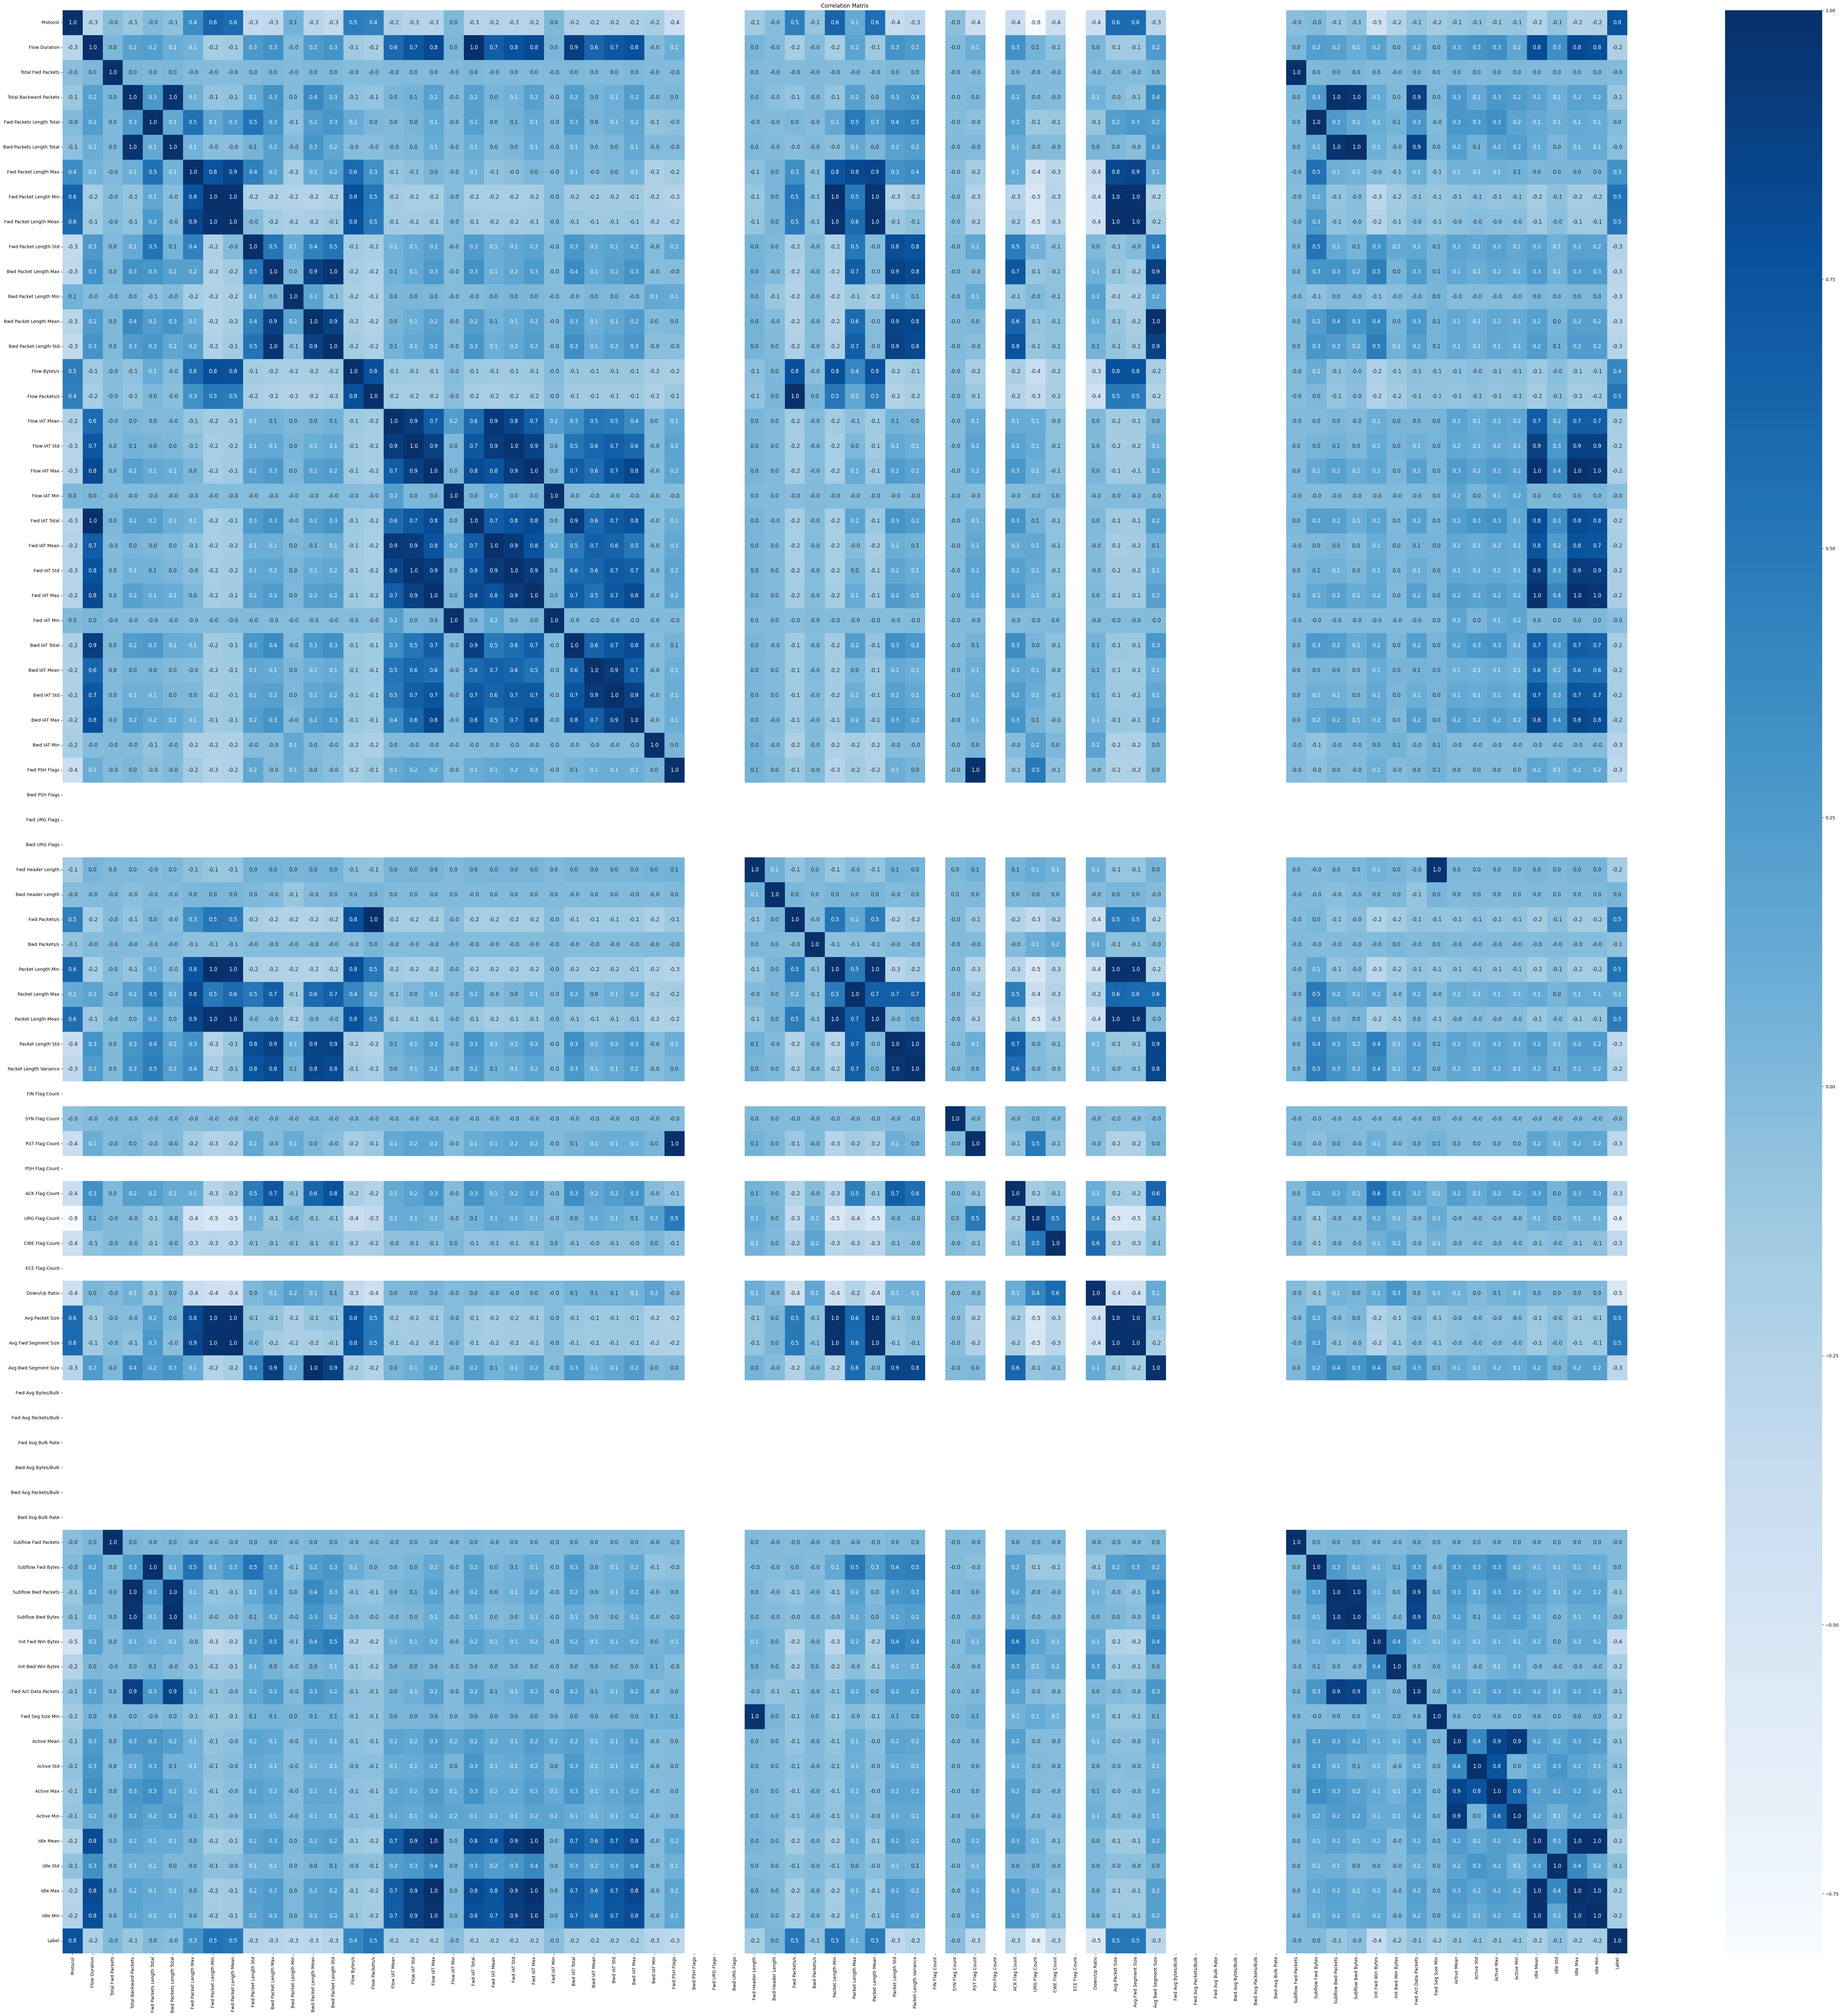

In [96]:
# Correlation heatmap
n_numeric_cols = len(train_df.select_dtypes(include=[np.number]).columns)
my_headmap(train_df.select_dtypes(include=[np.number]), size=(n_numeric_cols+1, n_numeric_cols+1))

## Future Engineering

### Feature Selection

In [97]:
# Features with a single unique value
single_val_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Columns with single value:", single_val_cols)

Columns with single value: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [98]:
# Remove columns with a single unique value
train_df.drop(single_val_cols, axis=1, inplace = True)
test_df.drop(single_val_cols, axis=1, inplace = True)

In [99]:
# Shape of the dataset after removing columns with a single unique value
print("Dataset shape after removing single value columns:", train_df.shape, test_df.shape)

Dataset shape after removing single value columns: (18970, 66) (13139, 66)


In [100]:
# Select only numeric columns
numerical_df = train_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

Total number of highly correlated columns: 36
Highly correlated columns are: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'URG Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [101]:
# Remove highly correlated columns from the dataset
train_df.drop(high_corr_cols, axis=1, inplace=True)
test_df.drop(high_corr_cols, axis=1, inplace=True)

In [102]:
# Shape of the dataset after removing highly correlated columns
print("Dataset shape after removing highly correlated columns:", train_df.shape, test_df.shape)

Dataset shape after removing highly correlated columns: (18970, 30) (13139, 30)


### Train Test Validation Split

In [103]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop("Label", axis=1),
    train_df["Label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)

# Dữ liệu test
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]

# -------------------
# Thống kê số lượng mỗi lớp
print("\n📊 Số lượng mẫu theo lớp trong tập Train:")
print(pd.Series(le.inverse_transform(y_train)).value_counts())

print("\n📊 Số lượng mẫu theo lớp trong tập Validation:")
print(pd.Series(le.inverse_transform(y_val)).value_counts())

print("\n📊 Số lượng mẫu theo lớp trong tập Test:")
print(pd.Series(le.inverse_transform(y_test)).value_counts())


📊 Số lượng mẫu theo lớp trong tập Train:
MSSQL      6702
Benign     6586
LDAP       1508
NetBIOS     380
Name: count, dtype: int64

📊 Số lượng mẫu theo lớp trong tập Validation:
MSSQL      1676
Benign     1646
LDAP        377
NetBIOS      95
Name: count, dtype: int64

📊 Số lượng mẫu theo lớp trong tập Test:
MSSQL      6212
Benign     4889
LDAP       1440
NetBIOS     598
Name: count, dtype: int64


In [104]:
print(X_train.shape, X_val.shape, X_test.shape)

(15176, 29) (3794, 29) (13139, 29)


In [105]:
print(y_train.shape, y_val.shape, y_test.shape)


(15176,) (3794,) (13139,)


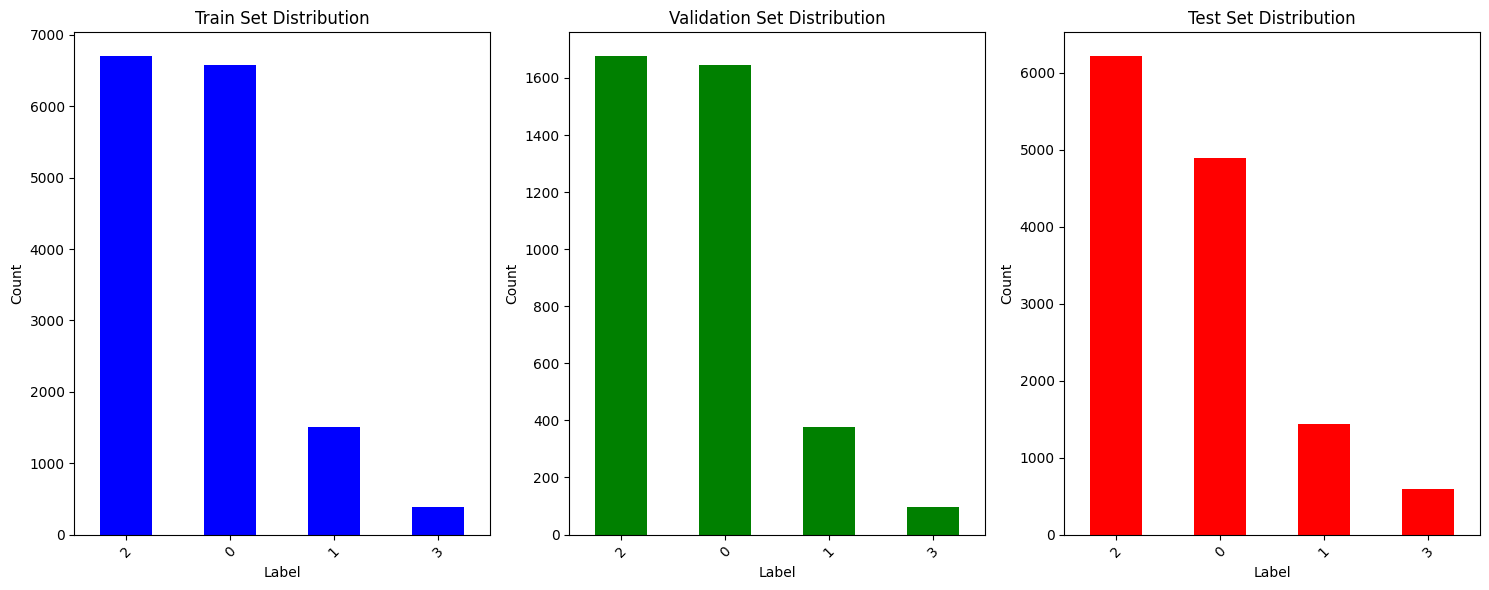

In [106]:
train_distribution = y_train.value_counts()
val_distribution = y_val.value_counts()
test_distribution = y_test.value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
train_distribution.plot(kind='bar', color='blue')
plt.title('Train Set Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
val_distribution.plot(kind='bar', color='green')
plt.title('Validation Set Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
test_distribution.plot(kind='bar', color='red')
plt.title('Test Set Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Feature Encoding

In [107]:
# Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [108]:
print("Label mapping:", label_map)


Label mapping: {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3)}


### Feature Scaling

In [109]:

# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [110]:
# Giả sử X_train, y_train đã có sau bước scaling
counter_before = Counter(y_train)
print("Counts before SMOTE:", counter_before)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

counter_after = Counter(y_train_res)
print("Counts after SMOTE: ", counter_after)



Counts before SMOTE: Counter({np.int64(2): 6702, np.int64(0): 6586, np.int64(1): 1508, np.int64(3): 380})
Counts after SMOTE:  Counter({np.int64(0): 6702, np.int64(2): 6702, np.int64(1): 6702, np.int64(3): 6702})


In [111]:
# Dữ liệu cho biểu đồ

classes = list(counter_before.keys())
before_counts = [counter_before[c] for c in classes]
after_counts  = [counter_after[c]  for c in classes]

x = np.arange(len(classes))
width = 0.35

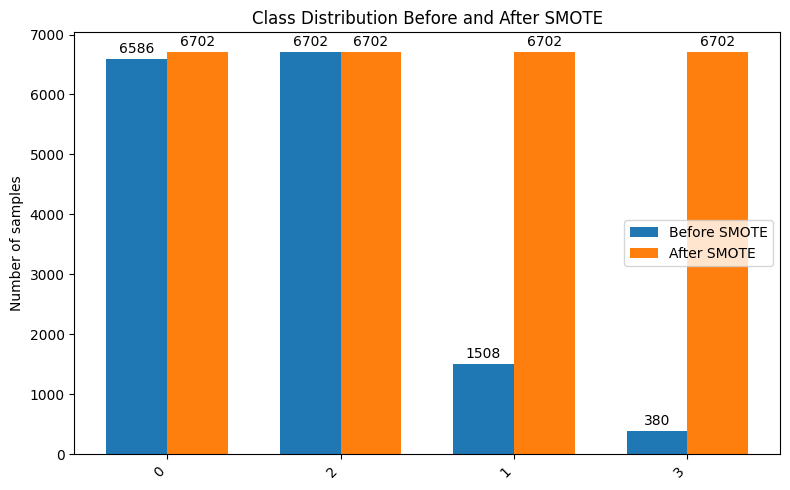

In [112]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, before_counts, width, label='Before SMOTE')
bars2 = ax.bar(x + width/2, after_counts,  width, label='After SMOTE')


for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 50, f'{int(h)}',
            ha='center', va='bottom')
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 50, f'{int(h)}',
            ha='center', va='bottom')
    
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('Number of samples')
ax.set_title('Class Distribution Before and After SMOTE')
ax.legend()
plt.tight_layout()
plt.show()

In [113]:
# Convert target to one-hot encoding for neural networks
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [114]:
print("\n--- PHÂN PHỐI DỮ LIỆU ---")
train_labels = pd.Series(y_train).map(label_map).value_counts()
val_labels = pd.Series(y_val).map(label_map).value_counts()
test_labels = pd.Series(y_test).map(label_map).value_counts()

print("Phân phối nhãn trong tập Train:")
print(train_labels)
print("\nPhân phối nhãn trong tập Validation:")
print(val_labels)
print("\nPhân phối nhãn trong tập Test:")
print(test_labels)



--- PHÂN PHỐI DỮ LIỆU ---
Phân phối nhãn trong tập Train:
2    6702
0    6586
1    1508
3     380
Name: count, dtype: int64

Phân phối nhãn trong tập Validation:
2    1676
0    1646
1     377
3      95
Name: count, dtype: int64

Phân phối nhãn trong tập Test:
2    6212
0    4889
1    1440
3     598
Name: count, dtype: int64


In [115]:
# Reshape data for CNN and LSTM (samples, time steps, features)
# For CNN and LSTM, we need 3D data: [samples, time steps, features]
# Since this is tabular data, we'll use 1 time step
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [116]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_positional_encoding(input_dim, output_dim):
    position = np.arange(input_dim)[:, np.newaxis]
    div_term = np.exp(np.arange(0, output_dim, 2) * -(np.log(10000.0) / output_dim))
    pe = np.zeros((input_dim, output_dim))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    pe = pe[np.newaxis, ...]  # Shape: (1, input_dim, output_dim)
    return tf.constant(pe, dtype=tf.float32)

def create_transformer_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)  # (seq_len, feature_dim)
    x = Dense(128, activation='relu')(input_layer)

    # Positional encoding
    positional_encoding = get_positional_encoding(input_shape[0], 128)
    x = Add()([x, positional_encoding])  # Broadcasting ok

    # Multi-head attention
    att = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, att])
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)

    # Feed-forward Network (FFN)
    ffn = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    ffn = Dropout(0.4)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



In [117]:
def save_training_artifacts(train_df, test_df, model=None, save_dir=r"C:\Users\Podo\Downloads\DACS\data"):
    """
    Lưu dữ liệu huấn luyện và mô hình vào thư mục chỉ định.
    """

    os.makedirs(save_dir, exist_ok=True)

    train_path = os.path.join(save_dir, "train_data.parquet")
    test_path = os.path.join(save_dir, "test_data.parquet")
    model_path = os.path.join(save_dir, "trained_model.keras")

    if not os.path.exists(train_path):
        train_df.to_parquet(train_path, index=False)
        print(f"✅ Train data saved to: {train_path}")
    else:
        print(f"🔁 Train data already exists at: {train_path}")

    if not os.path.exists(test_path):
        test_df.to_parquet(test_path, index=False)
        print(f"✅ Test data saved to: {test_path}")
    else:
        print(f"🔁 Test data already exists at: {test_path}")

    if model:
        model.save(model_path)
        print(f"✅ Model saved to: {model_path}")


In [118]:
def train_deep_models(X_train, X_val, y_train_cat, y_val_cat, train_df, test_df, epochs=10):
    scores_list = []
    history_dict = {}
    trained_models = {}

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    models = {
        "CNN": create_cnn_model(X_train.shape[1:], y_train_cat.shape[1]),
        "LSTM": create_lstm_model(X_train.shape[1:], y_train_cat.shape[1]),
        "Transformer": create_transformer_model(X_train.shape[1:], y_train_cat.shape[1]),
    }

    print("🚀 Training Deep Learning Models:")

    for name, model in tqdm(models.items(), desc="Training Models", ncols=100):
        print(f"\n🔁 Training {name}...")
        history = model.fit(
            X_train, y_train_cat,
            epochs=epochs,
            batch_size=64,
            steps_per_epoch=int(len(X_train) / 128),
            validation_data=(X_val, y_val_cat),
            callbacks=[early_stop],
            verbose=0
        )

        # 🔽 Lưu lại dữ liệu & model
        save_dir = fr"E:\Project\DACS\data\{name.lower()}"
        save_training_artifacts(train_df, test_df, model, save_dir=save_dir)

        history_dict[name] = history
        trained_models[name] = model
        scores_list.append(
            evaluate_model(model, X_val, np.argmax(y_val_cat, axis=1), y_val_cat, name)
        )

    return scores_list, history_dict, trained_models

In [119]:
def evaluate_model(model, X_test, y_test, y_test_cat, model_name):
    """
    Đánh giá mô hình deep learning:
      - Tính accuracy, precision, recall (weighted), F1, ROC AUC
      - Tính recall cho từng lớp
      - Vẽ confusion matrix
      - In recall từng lớp
    """

    # 1) Dự đoán xác suất từng lớp cho tập test
    y_pred_prob = model.predict(X_test)            # Kích thước (n_samples, n_classes)
    y_pred      = np.argmax(y_pred_prob, axis=1)   # Chọn nhãn có xác suất cao nhất

    # 2) Tính các chỉ số chung (cho multiclass dưới dạng weighted)
    accuracy        = accuracy_score(y_test, y_pred)
    precision       = precision_score(
        y_test, y_pred,
        average='weighted', zero_division=0
    )
    recall_weighted = recall_score(
        y_test, y_pred,
        average='weighted', zero_division=0
    )
    f1              = f1_score(
        y_test, y_pred,
        average='weighted'
    )

    # 3) Tính ROC AUC
    # - Nếu multiclass: multi_class='ovr', average='weighted'
    # - Nếu binary: lấy xác suất lớp positive (cột 1)
    if y_test_cat.shape[1] > 2:
        roc_auc = roc_auc_score(
            y_test_cat, y_pred_prob,
            multi_class='ovr', average='weighted'
        )
    else:
        roc_auc = roc_auc_score(
            y_test_cat, y_pred_prob[:, 1]
        )

    # 4) Tính recall cho từng lớp (không trung bình)
    recall_per_class = recall_score(
        y_test, y_pred,
        average=None, zero_division=0
    )

    # 5) Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    class_names = [label_map[i] for i in range(len(label_map))]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6) In recall cho từng lớp ra console
    print(f"\nRecall theo từng lớp ({model_name}):")
    for i, label in label_map.items():
        print(f"  {label}: {recall_per_class[i]:.4f}")

    # 7) Trả về kết quả chung dưới dạng dict
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (weighted)": recall_weighted,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

🚀 Training Deep Learning Models:


Training Models:   0%|                                                        | 0/3 [00:00<?, ?it/s]


🔁 Training CNN...
🔁 Train data already exists at: E:\Project\DACS\data\cnn\train_data.parquet
🔁 Test data already exists at: E:\Project\DACS\data\cnn\test_data.parquet
✅ Model saved to: E:\Project\DACS\data\cnn\trained_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


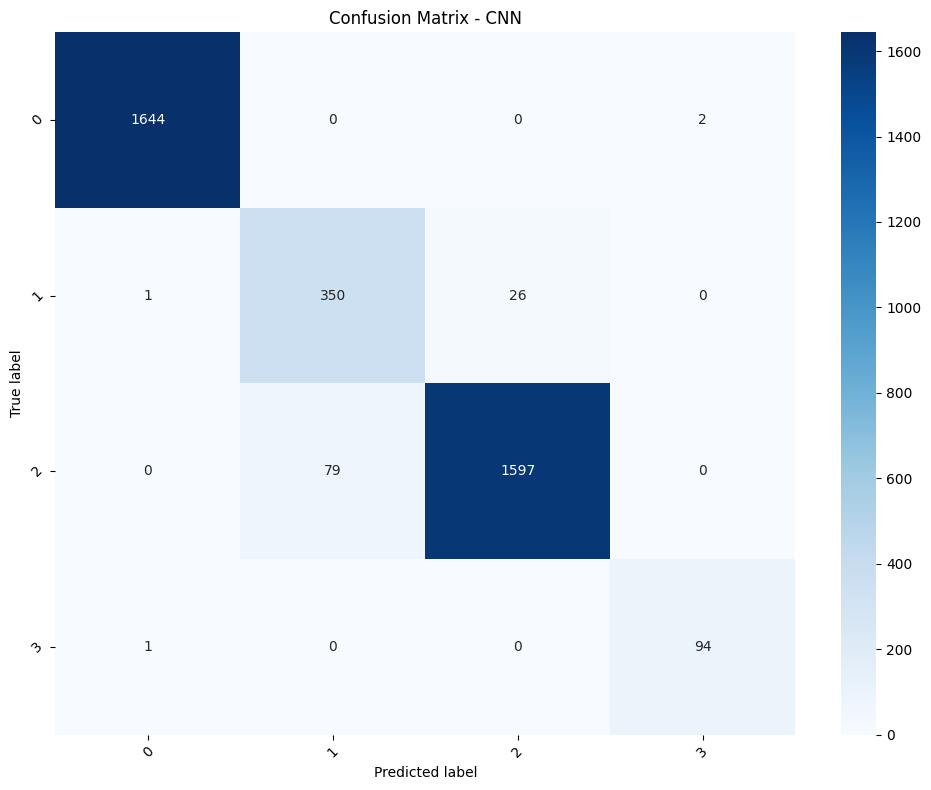

Training Models:  33%|████████████████                                | 1/3 [00:04<00:08,  4.22s/it]


Recall theo từng lớp (CNN):
  0: 0.9988
  1: 0.9284
  2: 0.9529
  3: 0.9895

🔁 Training LSTM...


In [ ]:
#Gọi train

scores_list, history_dict, trained_models = train_deep_models(
    X_train_reshaped,
    X_val_reshaped,
    y_train_cat,
    y_val_cat,
    train_df,       
    test_df,        
    epochs=10
)
scores_df = pd.DataFrame(scores_list)

# 3) In ra kết quả
print("\n📊 Model Comparison:")
print(scores_df)

# 4) (Tuỳ chọn) Vẽ biểu đồ so sánh độ chính xác giữa các model
plt.figure(figsize=(6,4))
scores_df.set_index('Model')['Accuracy'].plot(kind='bar', rot=0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()




In [ ]:
# Unpack ba giá trị từ hàm train_deep_models

# Tạo DataFrame để so sánh các mô hình
scores_df = pd.DataFrame(scores_list)



# In kết quả so sánh các mô hình
print("\n📊 Model Comparison:")
print(scores_df)


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initialize plot for ROC curves
plt.figure(figsize=(10, 8))

# Generate ROC curves for each model
for model_name, model in trained_models.items():  # Thay train_models thành trained_models
    y_pred_prob = model.predict(X_test_reshaped)

    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_cat[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - {label_map[i]} (AUC = {roc_auc:.4f})')

# Add random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()


In [ ]:

models = scores_df['Model']
accuracy = scores_df['Accuracy']

# Generate a color map
colors = cm.viridis(np.linspace(0, 1, len(models)))

# Plotting the accuracy points with color for each model
plt.figure(figsize=(10, 6))
for i, (model, acc) in enumerate(zip(models, accuracy)):
    plt.plot(model, acc, marker='o', color=colors[i], markersize=8, label=model)

# Adding a line that passes through the points
plt.plot(models, accuracy, linestyle='-', color='#7393B3', linewidth=2, label="Accuracy Line")

# Customizing the plot
plt.title("Accuracy Scores for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1) 
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot with legend at the bottom right
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(unique_labels.values(), unique_labels.keys(), loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

### Export the Best Model (Random Forest) for Deployment


In [ ]:
# ✅ Tìm model có độ chính xác cao nhất
best_model_idx = np.argmax(scores_df['Accuracy'])
best_model_name = scores_df.iloc[best_model_idx]['Model']
print(f"\n✅ Best model based on accuracy: {best_model_name}")

# 🎯 Lấy mô hình tương ứng từ trained_models
best_model = trained_models[best_model_name]

# 💾 Save mô hình (.h5)
best_model.save(f"{best_model_name}_ddos_model.h5")
print(f"✅ Saved H5 model: {best_model_name}_ddos_model.h5")


### Recommendation


### Conclusion

Through this project, I evaluated several machine learning models for DDoS attack detection, aiming to identify the most effective model for classifying various types of DDoS attacks. The results provide insights into the performance of each model, and can help in building more robust cybersecurity systems that are capable of detecting and defending against DDoS attacks in real-world networks.

For more information about the dataset, you can visit the official [CICDDoS2019 Dataset Page](https://www.unb.ca/cic/datasets/ddos-2019.html).